In [49]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.linalg import sqrtm
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.impute import KNNImputer
from scipy import stats
import warnings
from sdv.single_table.ctgan import CTGAN
import os
import missingno as msno
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", None, "display.max_columns", 1000)

In [2]:
data = pd.read_csv("./cirrhosis.csv")

data.head(5)

ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N            Y       Y   
2   3    1012      D  D-penicillamine  25594   M       N            N       N   
3   4    1925      D  D-penicillamine  19994   F       N            Y       Y   
4   5    1504     CL          Placebo  13918   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

# Univariate Analysis

### EDA Pre Imputation(EDA before handling of missing values)
--------------

This is the analysis done before the imputation of values for missing values


In [3]:
data_copy = data.copy()
data_copy.head()

ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N            Y       Y   
2   3    1012      D  D-penicillamine  25594   M       N            N       N   
3   4    1925      D  D-penicillamine  19994   F       N            Y       Y   
4   5    1504     CL          Placebo  13918   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [4]:
# Convert Age from number of dats to years
data_copy['Age'] = (data_copy['Age'] / 365.25).astype(int)
data_copy.head()

ID  N_Days Status             Drug  Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine   58   F       Y            Y       Y   
1   2    4500      C  D-penicillamine   56   F       N            Y       Y   
2   3    1012      D  D-penicillamine   70   M       N            N       N   
3   4    1925      D  D-penicillamine   54   F       N            Y       Y   
4   5    1504     CL          Placebo   38   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [5]:
# Drop ID column as it is not needed for analysis
# ID is a unique identifier and does not contribute to the analysis
data_copy.drop(columns=['ID'], inplace=True)
data_copy.head()

N_Days Status             Drug  Age Sex Ascites Hepatomegaly Spiders Edema  \
0     400      D  D-penicillamine   58   F       Y            Y       Y     Y   
1    4500      C  D-penicillamine   56   F       N            Y       Y     N   
2    1012      D  D-penicillamine   70   M       N            N       N     S   
3    1925      D  D-penicillamine   54   F       N            Y       Y     S   
4    1504     CL          Placebo   38   F       N            Y       Y     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0       14.5        261.0     2.60   156.0    1718.0  137.95          172.0   
1        1.1        302.0     4.14    54.0    7394.8  113.52           88.0   
2        1.4        176.0     3.48   210.0     516.0   96.10           55.0   
3        1.8        244.0     2.54    64.0    6121.8   60.63           92.0   
4        3.4        279.0     3.53   143.0     671.0  113.15           72.0   

   Platelets  Prothrombin  Stage  
0      190.0         12.2    4.0  
1      221.0         10.6    3.0  
2      151.0         12.0    4.0  
3      183.0         10.3    4.0  
4      136.0         10.9    3.0

In [6]:
data_copy.describe(include="all").T # Descriptive analysis for both numerical and categorical data

count unique              top freq         mean          std  \
N_Days         418.0    NaN              NaN  NaN  1917.782297  1104.672992   
Status           418      3                C  232          NaN          NaN   
Drug             312      2  D-penicillamine  158          NaN          NaN   
Age            418.0    NaN              NaN  NaN    50.294258    10.471934   
Sex              418      2                F  374          NaN          NaN   
Ascites          312      2                N  288          NaN          NaN   
Hepatomegaly     312      2                Y  160          NaN          NaN   
Spiders          312      2                N  222          NaN          NaN   
Edema            418      3                N  354          NaN          NaN   
Bilirubin      418.0    NaN              NaN  NaN     3.220813     4.407506   
Cholesterol    284.0    NaN              NaN  NaN   369.510563   231.944545   
Albumin        418.0    NaN              NaN  NaN      3.49744     0.424972   
Copper         310.0    NaN              NaN  NaN    97.648387     85.61392   
Alk_Phos       312.0    NaN              NaN  NaN  1982.655769  2140.388824   
SGOT           312.0    NaN              NaN  NaN   122.556346    56.699525   
Tryglicerides  282.0    NaN              NaN  NaN   124.702128    65.148639   
Platelets      407.0    NaN              NaN  NaN    257.02457    98.325585   
Prothrombin    416.0    NaN              NaN  NaN    10.731731        1.022   
Stage          412.0    NaN              NaN  NaN     3.024272     0.882042   

                 min      25%     50%     75%      max  
N_Days          41.0  1092.75  1730.0  2613.5   4795.0  
Status           NaN      NaN     NaN     NaN      NaN  
Drug             NaN      NaN     NaN     NaN      NaN  
Age             26.0     42.0    51.0    58.0     78.0  
Sex              NaN      NaN     NaN     NaN      NaN  
Ascites          NaN      NaN     NaN     NaN      NaN  
Hepatomegaly     NaN      NaN     NaN     NaN      NaN  
Spiders          NaN      NaN     NaN     NaN      NaN  
Edema            NaN      NaN     NaN     NaN      NaN  
Bilirubin        0.3      0.8     1.4     3.4     28.0  
Cholesterol    120.0    249.5   309.5   400.0   1775.0  
Albumin         1.96   3.2425    3.53    3.77     4.64  
Copper           4.0    41.25    73.0   123.0    588.0  
Alk_Phos       289.0    871.5  1259.0  1980.0  13862.4  
SGOT           26.35     80.6   114.7   151.9   457.25  
Tryglicerides   33.0    84.25   108.0   151.0    598.0  
Platelets       62.0    188.5   251.0   318.0    721.0  
Prothrombin      9.0     10.0    10.6    11.1     18.0  
Stage            1.0      2.0     3.0     4.0      4.0

In [7]:
data_copy.describe().T

count         mean          std     min        25%      50%  \
N_Days         418.0  1917.782297  1104.672992   41.00  1092.7500  1730.00   
Age            418.0    50.294258    10.471934   26.00    42.0000    51.00   
Bilirubin      418.0     3.220813     4.407506    0.30     0.8000     1.40   
Cholesterol    284.0   369.510563   231.944545  120.00   249.5000   309.50   
Albumin        418.0     3.497440     0.424972    1.96     3.2425     3.53   
Copper         310.0    97.648387    85.613920    4.00    41.2500    73.00   
Alk_Phos       312.0  1982.655769  2140.388824  289.00   871.5000  1259.00   
SGOT           312.0   122.556346    56.699525   26.35    80.6000   114.70   
Tryglicerides  282.0   124.702128    65.148639   33.00    84.2500   108.00   
Platelets      407.0   257.024570    98.325585   62.00   188.5000   251.00   
Prothrombin    416.0    10.731731     1.022000    9.00    10.0000    10.60   
Stage          412.0     3.024272     0.882042    1.00     2.0000     3.00   

                   75%       max  
N_Days         2613.50   4795.00  
Age              58.00     78.00  
Bilirubin         3.40     28.00  
Cholesterol     400.00   1775.00  
Albumin           3.77      4.64  
Copper          123.00    588.00  
Alk_Phos       1980.00  13862.40  
SGOT            151.90    457.25  
Tryglicerides   151.00    598.00  
Platelets       318.00    721.00  
Prothrombin      11.10     18.00  
Stage             4.00      4.00

In [8]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

In [9]:
df_num = data_copy.select_dtypes(include=['int64', 'float64'])
df_num.head()



N_Days  Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     400   58       14.5        261.0     2.60   156.0    1718.0  137.95   
1    4500   56        1.1        302.0     4.14    54.0    7394.8  113.52   
2    1012   70        1.4        176.0     3.48   210.0     516.0   96.10   
3    1925   54        1.8        244.0     2.54    64.0    6121.8   60.63   
4    1504   38        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

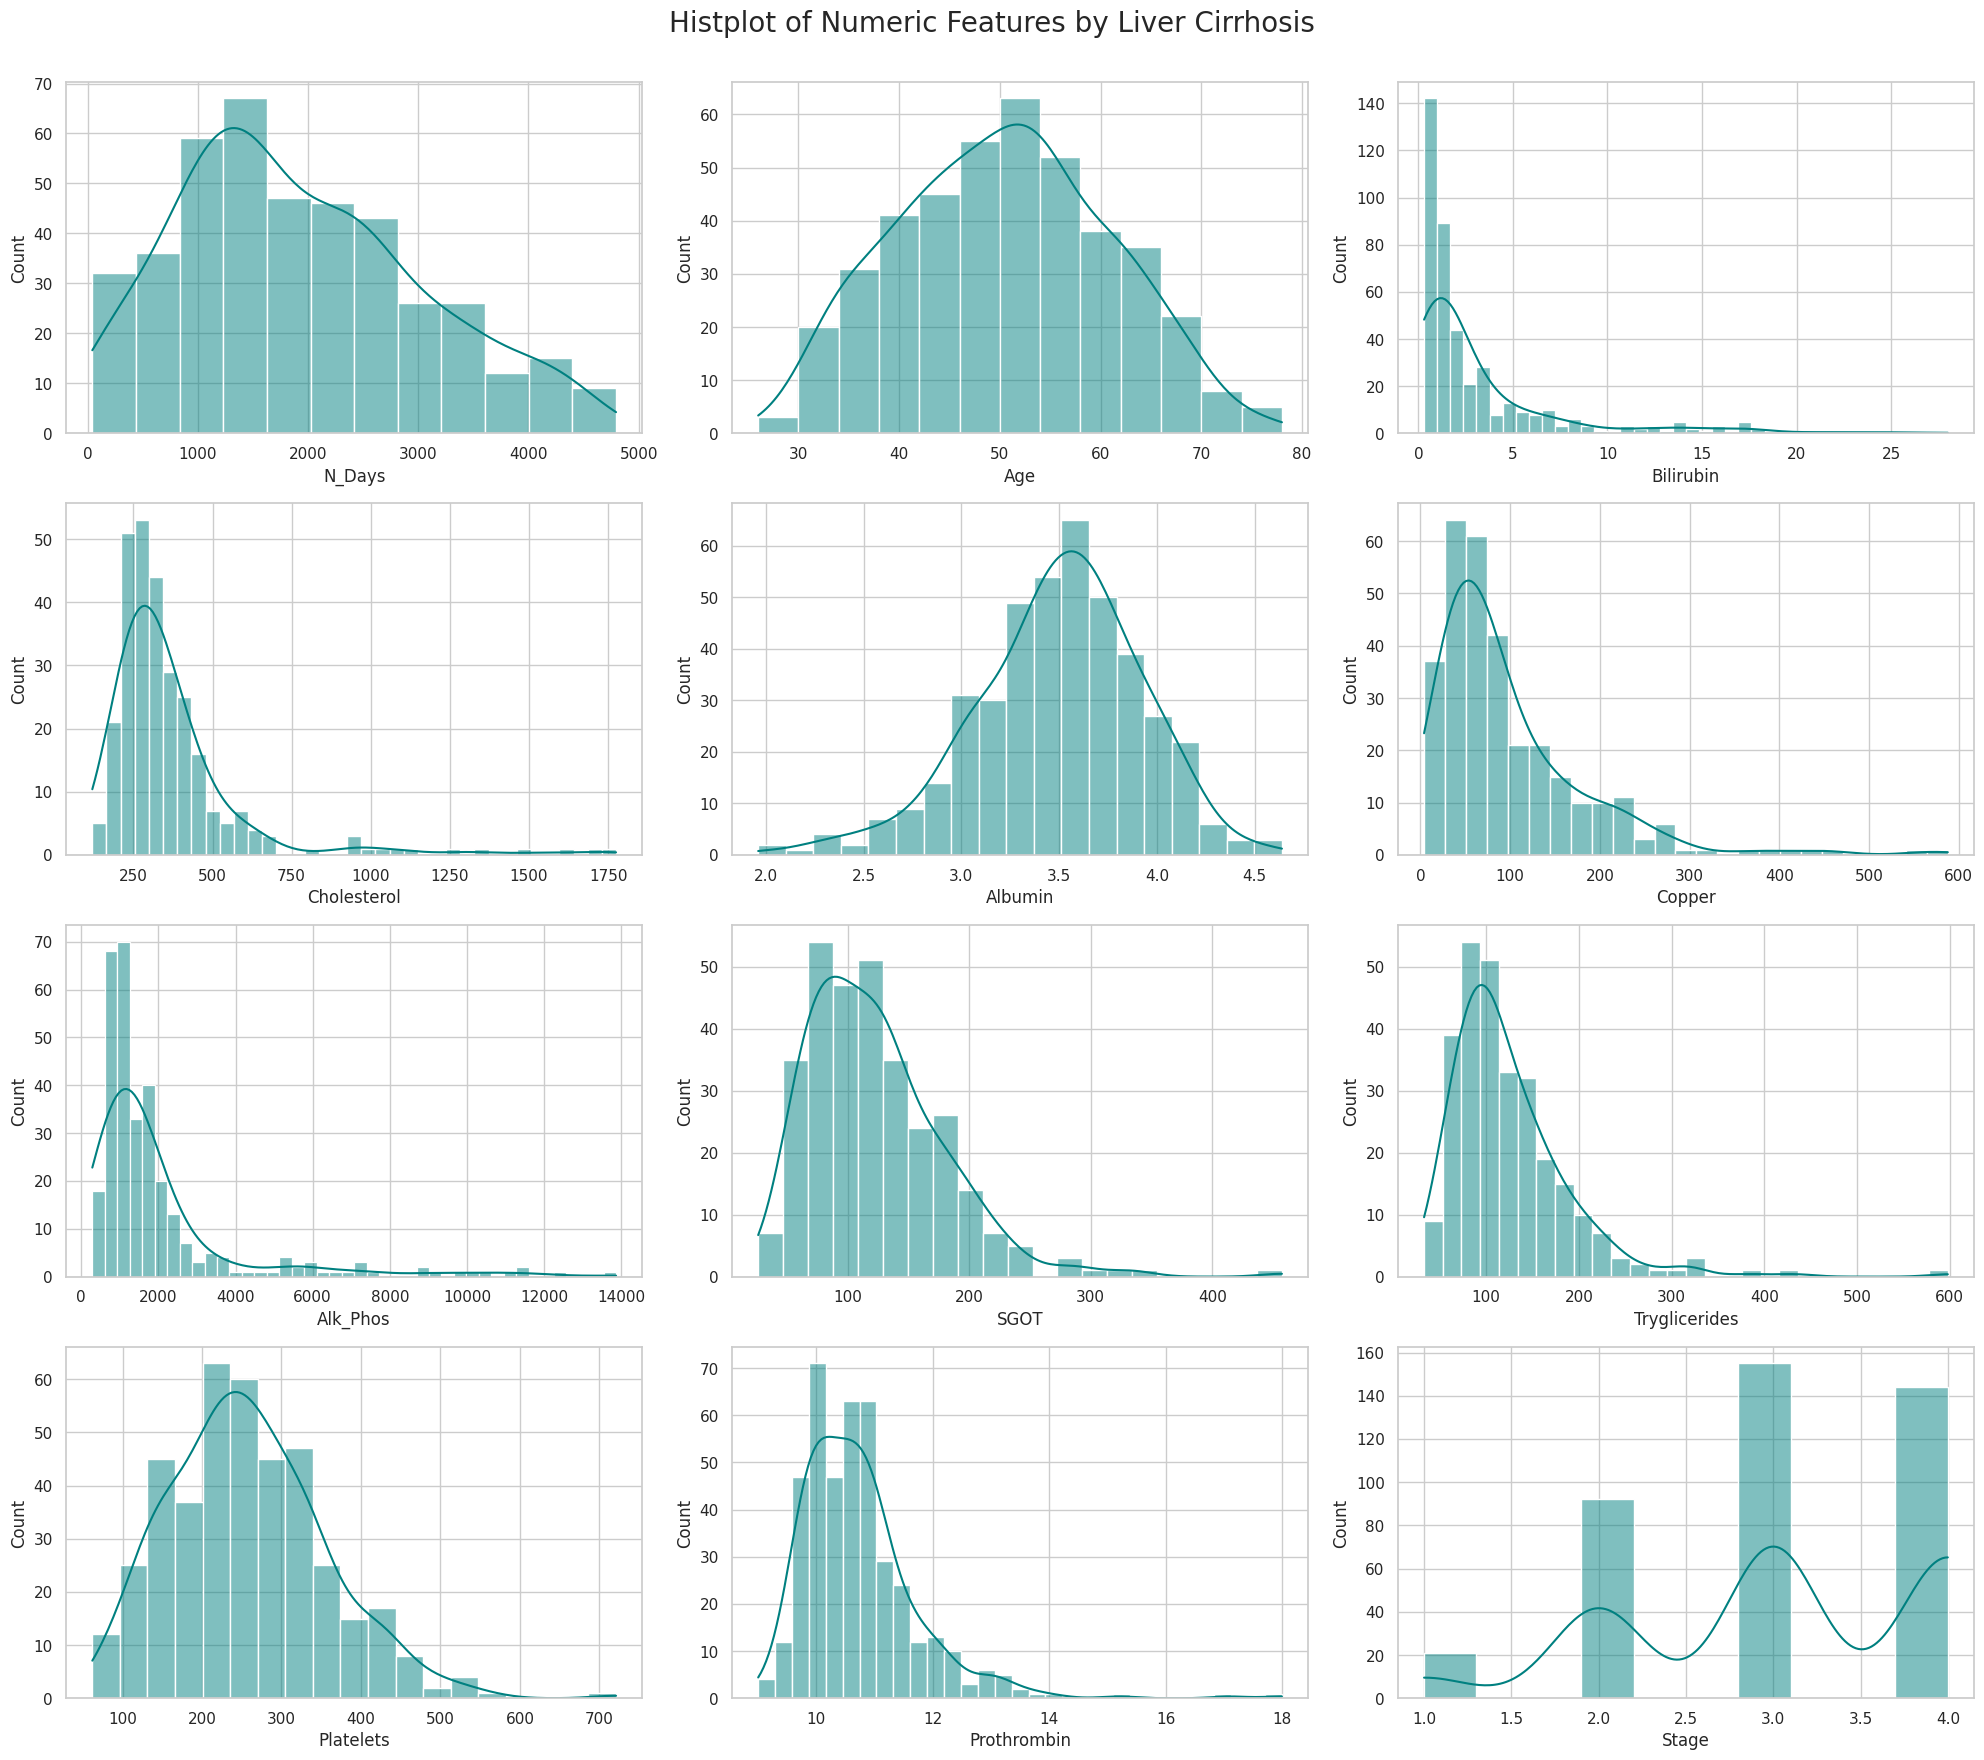

In [10]:
# Plot Histograms of numeric features
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_num):
    plt.subplot(6, 3, i + 1)
    sns.histplot(data=df_num, x=col, palette='viridis', color=(0, 0.5, 0.5), kde=True)
    # plt.title(f'{col} by Stage')
    plt.tight_layout()

plt.suptitle('Histplot of Numeric Features by Liver Cirrhosis', fontsize=20, y=1.02)
plt.show()

In [11]:
cat_df = data_copy.select_dtypes(include=['object'])
cat_df.head()


Status             Drug Sex Ascites Hepatomegaly Spiders Edema
0      D  D-penicillamine   F       Y            Y       Y     Y
1      C  D-penicillamine   F       N            Y       Y     N
2      D  D-penicillamine   M       N            N       N     S
3      D  D-penicillamine   F       N            Y       Y     S
4     CL          Placebo   F       N            Y       Y     N

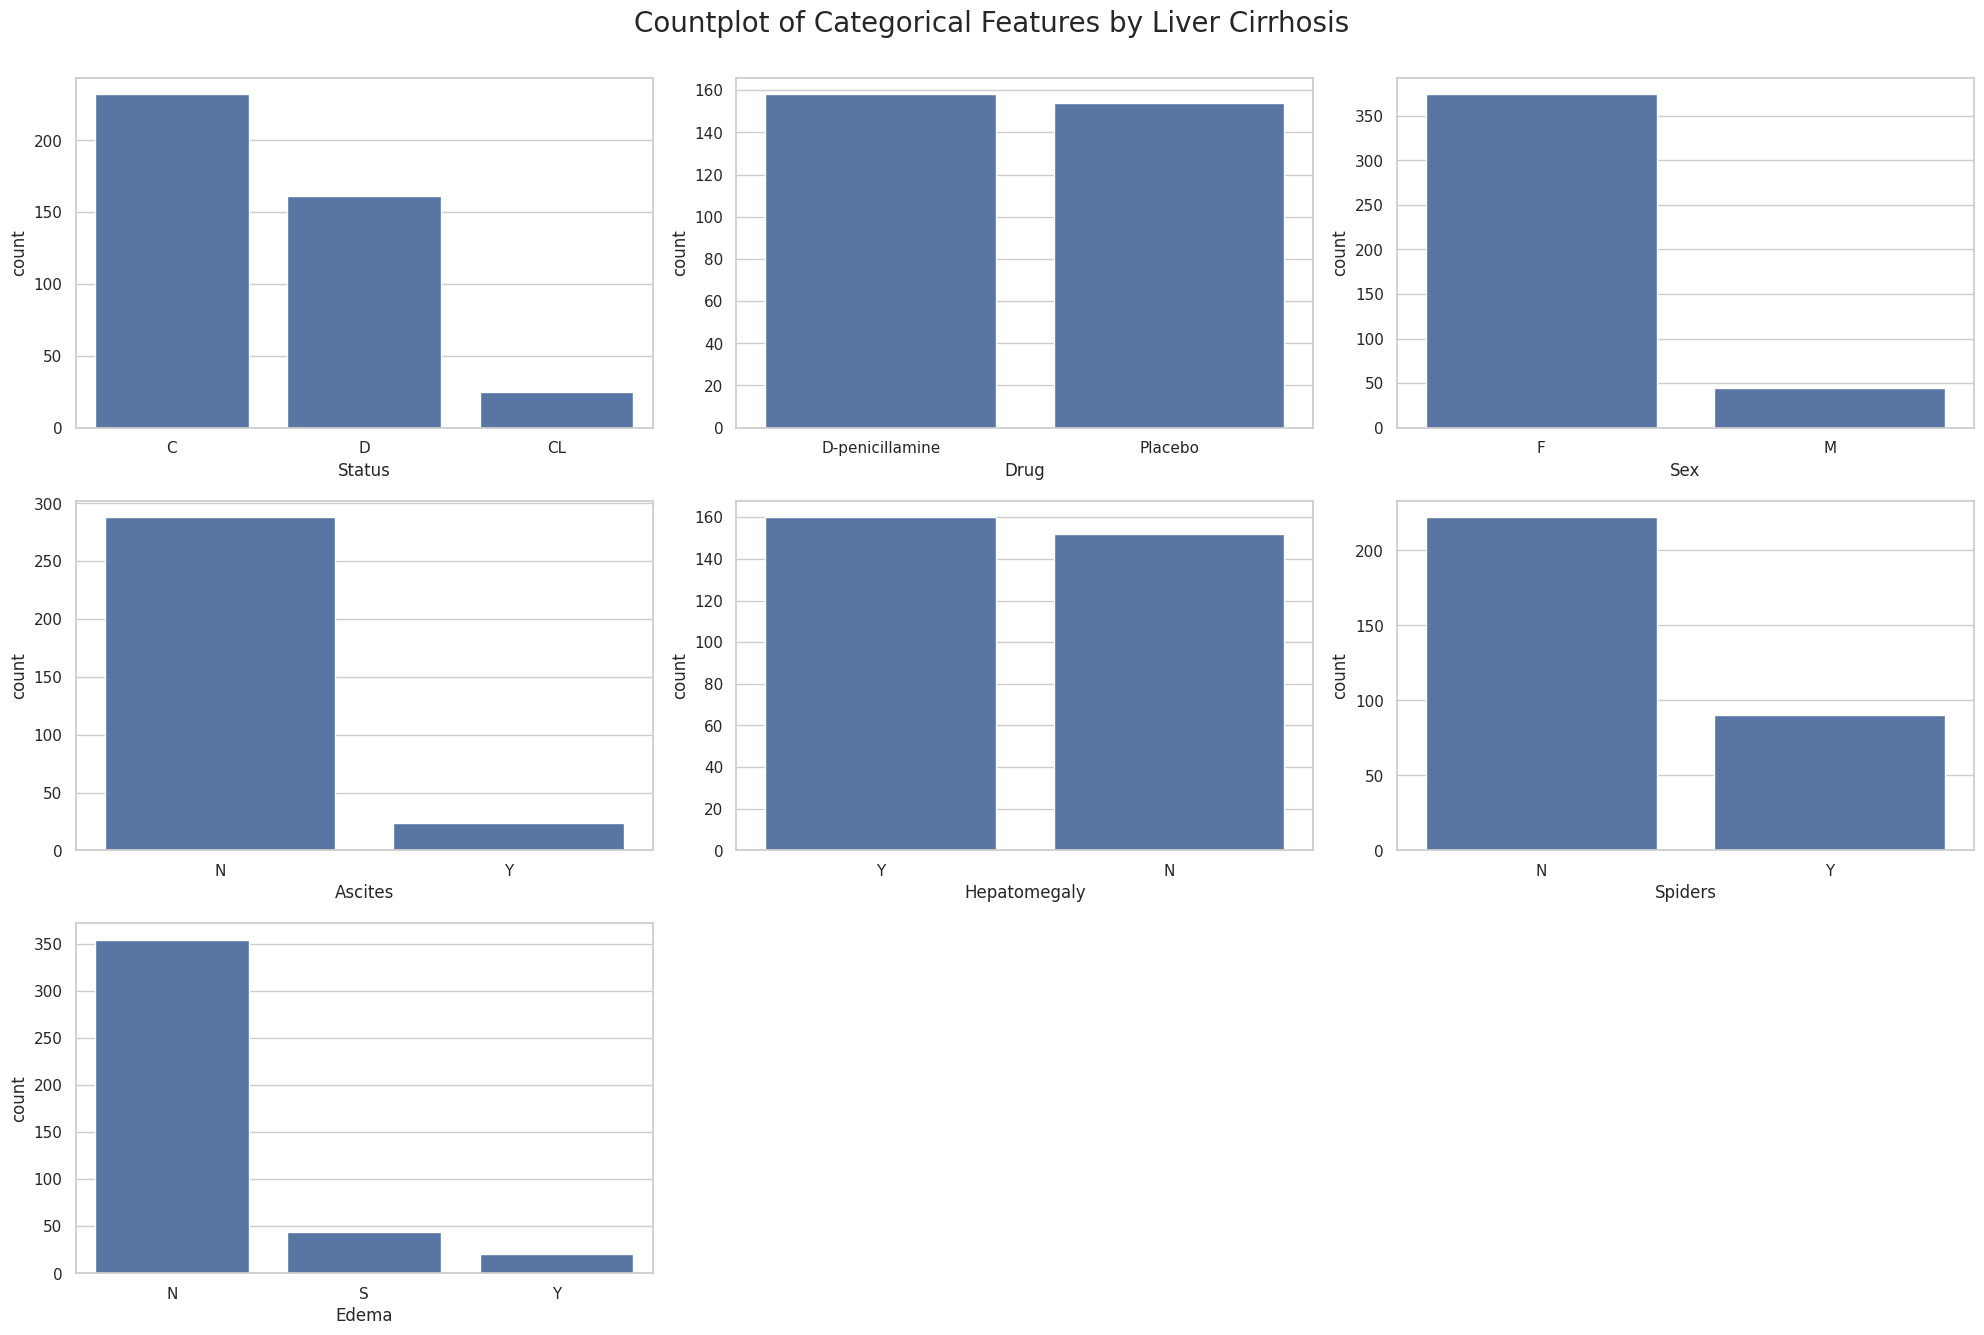

In [12]:
# Bar plot of categorical features
plt.figure(figsize=(20, 25))
for i, col in enumerate(cat_df):
    plt.subplot(6, 3, i + 1)
    sns.countplot(data=cat_df, x=col, order=cat_df[col].value_counts().index)
    # plt.title(f'{col} by Stage')
    plt.tight_layout()

plt.suptitle('Countplot of Categorical Features by Liver Cirrhosis', fontsize=20, y=1.02)
plt.show()

## Working with missingness
1. Pattern of Missing Values
To identify the type of missingness, we first check if missing values occur together or independently. A key observation is that 106 rows have missing values in Drug, Ascites, Hepatomegaly, Spiders, Edema, and Stage simultaneously. Let’s confirm this by analyzing the dataset.

<Axes: >

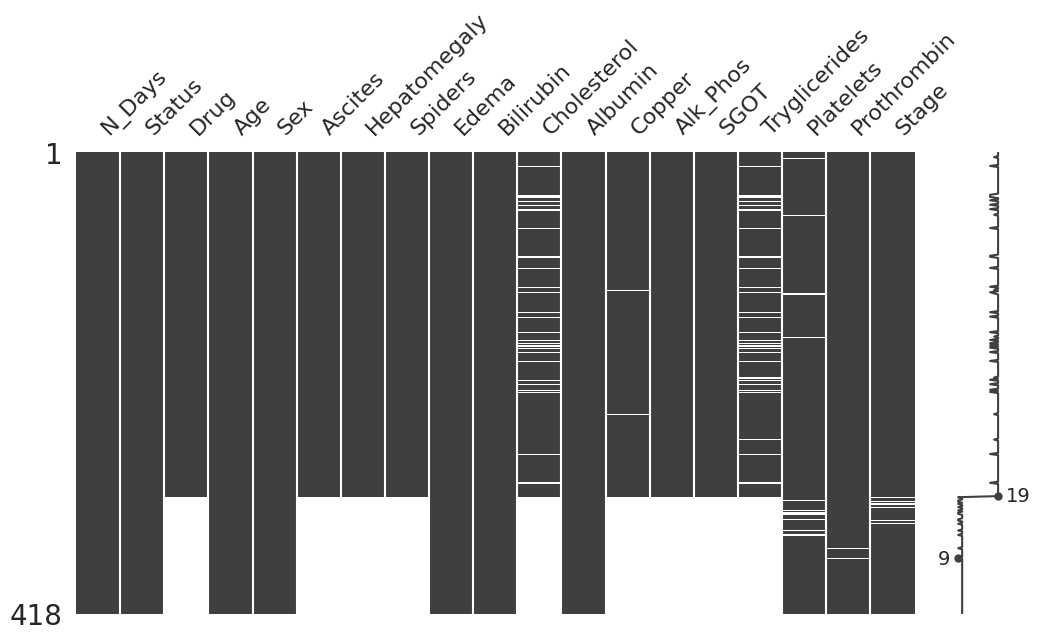

In [13]:
# Visualization of missing data
msno.matrix(data_copy, figsize=(12, 6))

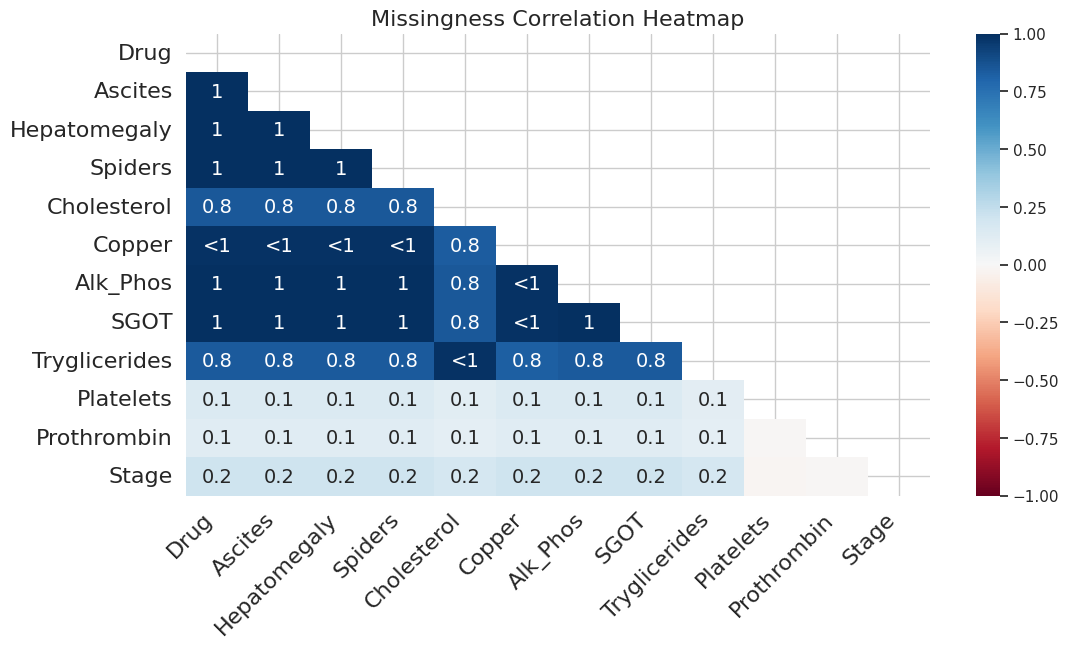

In [14]:
msno.heatmap(data_copy, figsize=(12, 6))
plt.title("Missingness Correlation Heatmap", fontsize=16);

#### 1. Missingness in Drug, Ascites, Hepatomegaly, Spiders, Copper, Alk_Phos, SGOT (106 rows missing all)

In [15]:
df_missingness = data.copy()

# Replace 'NA' with None for proper handling
df_missingness = df_missingness.replace('NA', None)

# Check rows where all specified columns are missing
missing_cols = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
rows_missing_all = df_missingness[missing_cols].isnull().all(axis=1)
print(f"Number of rows with all {missing_cols} missing: {rows_missing_all.sum()}")

Number of rows with all ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'] missing: 0


In [16]:
# Replace 'NA' with None for proper handling
df = df_missingness.replace('NA', None)

# Check missing values in each column
print("Missing Values per Column:")
print(df.isnull().sum())

Missing Values per Column:
ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64


In [17]:
# Replace 'NA' with None for proper handling
df = df_missingness.replace('NA', None)

# Check rows where specific columns are missing together
missing_cols = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Copper', 'Alk_Phos', 'SGOT']
rows_missing_all = df[missing_cols].isnull().all(axis=1)
print(f"Number of rows with all {missing_cols} missing: {rows_missing_all.sum()}")

# Check rows with at least one missing value in these columns
rows_missing_any = df[missing_cols].isnull().any(axis=1)
print(f"Number of rows with at least one missing value in {missing_cols}: {rows_missing_any.sum()}")

# Check if Stage missingness overlaps with these columns
rows_missing_stage = df['Stage'].isnull()
overlap_stage = df[rows_missing_stage & rows_missing_any].shape[0]
print(f"Number of rows with missing Stage and missing {missing_cols}: {overlap_stage}")

# Check missingness patterns
missing_pattern = df[missing_cols + ['Stage', 'Cholesterol', 'Tryglicerides']].isnull()
print("\nMissing Value Patterns (first 10 rows):")
print(missing_pattern.head(10))
print("\nCount of rows by number of missing columns:")
print(missing_pattern.sum(axis=1).value_counts())

Number of rows with all ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Copper', 'Alk_Phos', 'SGOT'] missing: 106
Number of rows with at least one missing value in ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Copper', 'Alk_Phos', 'SGOT']: 108
Number of rows with missing Stage and missing ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Copper', 'Alk_Phos', 'SGOT']: 6

Missing Value Patterns (first 10 rows):
    Drug  Ascites  Hepatomegaly  Spiders  Copper  Alk_Phos   SGOT  Stage  \
0  False    False         False    False   False     False  False  False   
1  False    False         False    False   False     False  False  False   
2  False    False         False    False   False     False  False  False   
3  False    False         False    False   False     False  False  False   
4  False    False         False    False   False     False  False  False   
5  False    False         False    False   False     False  False  False   
6  False    False         False    False   False     Fa

In [18]:
# Compare Bilirubin and Status in rows with/without missing Drug
rows_missing_block = df[missing_cols].isnull().all(axis=1)
print("Mean Bilirubin for missing block:", df[rows_missing_block]['Bilirubin'].mean())
print("Mean Bilirubin for non-missing block:", df[~rows_missing_block]['Bilirubin'].mean())
print("\nStatus distribution for missing block:")
print(df[rows_missing_block]['Status'].value_counts())
print("\nStatus distribution for non-missing block:")
print(df[~rows_missing_block]['Status'].value_counts())

Mean Bilirubin for missing block: 3.1169811320754715
Mean Bilirubin for non-missing block: 3.256089743589744

Status distribution for missing block:
Status
C     64
D     36
CL     6
Name: count, dtype: int64

Status distribution for non-missing block:
Status
C     168
D     125
CL     19
Name: count, dtype: int64


In [19]:
print("Mean Age for missing block:", df[rows_missing_block]['Age'].mean())
print("Mean Age for non-missing block:", df[~rows_missing_block]['Age'].mean())

Mean Age for missing block: 19310.14150943396
Mean Age for non-missing block: 18269.44230769231


### 2. Missingness in ```Stage``` (6 rows missing)
Higher Bilirubin or more Status=D in these 6 rows would confirm MNAR.


In [20]:
print("Mean Bilirubin for missing Stage:", df[df['Stage'].isnull()]['Bilirubin'].mean())
print("Mean Bilirubin for non-missing Stage:", df[df['Stage'].notnull()]['Bilirubin'].mean())
print("\nStatus distribution for missing Stage:")
print(df[df['Stage'].isnull()]['Status'].value_counts())

Mean Bilirubin for missing Stage: 2.75
Mean Bilirubin for non-missing Stage: 3.2276699029126217

Status distribution for missing Stage:
Status
D    4
C    2
Name: count, dtype: int64


### 3. Missingness in Cholesterol (134) and Tryglicerides (136)


In [21]:
print("Mean Age for missing Tryglicerides:", df[df['Tryglicerides'].isnull()]['Age'].mean())
print("Mean Age for non-missing Tryglicerides:", df[df['Tryglicerides'].notnull()]['Age'].mean())

Mean Age for missing Tryglicerides: 19130.117647058825
Mean Age for non-missing Tryglicerides: 18245.54964539007


# Bivariate Analysis

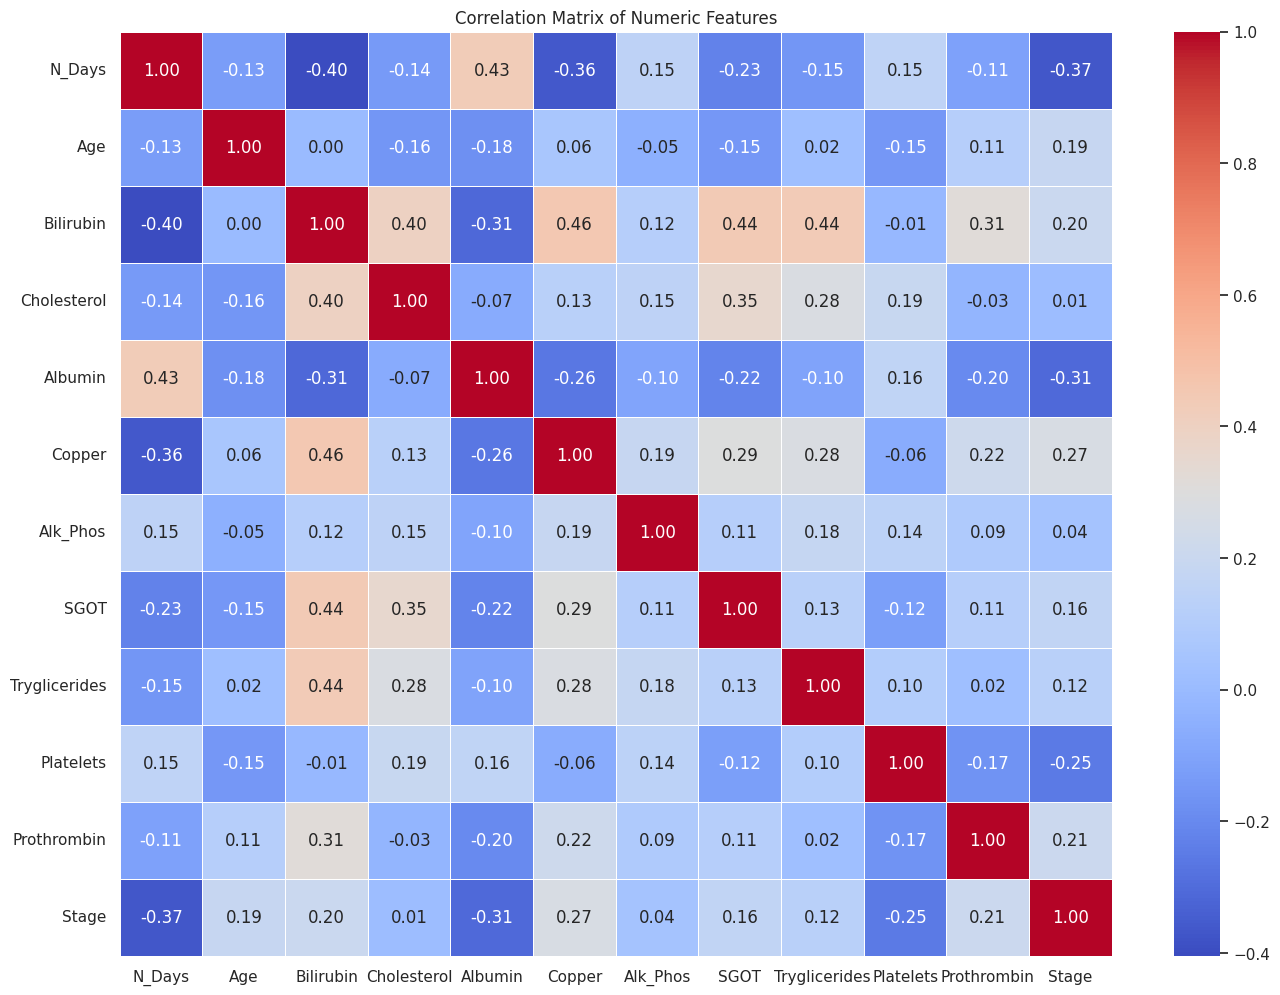

In [22]:
# Compute the correlation matrix for numeric columns
plt.figure(figsize=(16, 12))
corr = df_num.corr()

# Create a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [23]:
corr

N_Days       Age  Bilirubin  Cholesterol   Albumin    Copper  \
N_Days         1.000000 -0.126868  -0.403953    -0.138236  0.430829 -0.364809   
Age           -0.126868  1.000000   0.000246    -0.155939 -0.178980  0.059867   
Bilirubin     -0.403953  0.000246   1.000000     0.397129 -0.314177  0.456918   
Cholesterol   -0.138236 -0.155939   0.397129     1.000000 -0.069733  0.126115   
Albumin        0.430829 -0.178980  -0.314177    -0.069733  1.000000 -0.264771   
Copper        -0.364809  0.059867   0.456918     0.126115 -0.264771  1.000000   
Alk_Phos       0.149269 -0.049337   0.116984     0.149473 -0.101456  0.187357   
SGOT          -0.225492 -0.150934   0.441730     0.353246 -0.220047  0.293829   
Tryglicerides -0.153000  0.021122   0.436748     0.276830 -0.103417  0.279852   
Platelets      0.151361 -0.147654  -0.013435     0.191710  0.158659 -0.064403   
Prothrombin   -0.111470  0.113684   0.314894    -0.030811 -0.200592  0.218224   
Stage         -0.366193  0.186208   0.200731     0.011164 -0.305296  0.269400   

               Alk_Phos      SGOT  Tryglicerides  Platelets  Prothrombin  \
N_Days         0.149269 -0.225492      -0.153000   0.151361    -0.111470   
Age           -0.049337 -0.150934       0.021122  -0.147654     0.113684   
Bilirubin      0.116984  0.441730       0.436748  -0.013435     0.314894   
Cholesterol    0.149473  0.353246       0.276830   0.191710    -0.030811   
Albumin       -0.101456 -0.220047      -0.103417   0.158659    -0.200592   
Copper         0.187357  0.293829       0.279852  -0.064403     0.218224   
Alk_Phos       1.000000  0.112217       0.180082   0.143733     0.089384   
SGOT           0.112217  1.000000       0.126119  -0.120147     0.112174   
Tryglicerides  0.180082  0.126119       1.000000   0.103212     0.020122   
Platelets      0.143733 -0.120147       0.103212   1.000000    -0.167331   
Prothrombin    0.089384  0.112174       0.020122  -0.167331     1.000000   
Stage          0.041273  0.164945       0.123899  -0.253523     0.207802   

                  Stage  
N_Days        -0.366193  
Age            0.186208  
Bilirubin      0.200731  
Cholesterol    0.011164  
Albumin       -0.305296  
Copper         0.269400  
Alk_Phos       0.041273  
SGOT           0.164945  
Tryglicerides  0.123899  
Platelets     -0.253523  
Prothrombin    0.207802  
Stage          1.000000

In [70]:
df.head()

N_Days  Status  Drug       Age  Sex  Ascites  Hepatomegaly  Spiders  \
0 -1.375612       2     0  0.736729    0        1             1        1   
1  2.340341       0     0  0.545513    0        0             1        1   
2 -0.820938       2     0  1.884022    1        0             0        0   
3  0.006542       2     0  0.354298    0        0             1        1   
4 -0.375023       1     1 -1.175427    0        0             1        1   

   Edema  Bilirubin  Cholesterol   Albumin    Copper  Alk_Phos      SGOT  \
0      2   2.562152    -0.527844 -2.114296  0.694288 -0.107113  0.280692   
1      0  -0.481759    -0.326005  1.513818 -0.593132  2.889003 -0.201179   
2      1  -0.413611    -0.946291 -0.041088  1.375863 -0.741507 -0.544781   
3      1  -0.322748    -0.611534 -2.255651 -0.466915  2.217136 -1.244411   
4      0   0.040704    -0.439232  0.076708  0.530205 -0.659701 -0.208477   

   Tryglicerides  Platelets  Prothrombin  Stage  
0       0.869404  -0.690618     1.437359      8  
1      -0.627654  -0.371577    -0.131710      4  
2      -1.215784  -1.091992     1.241225      8  
3      -0.556366  -0.762660    -0.425910      8  
4      -0.912808  -1.246366     0.162491      4

# 3D plots for pre missing data analysis

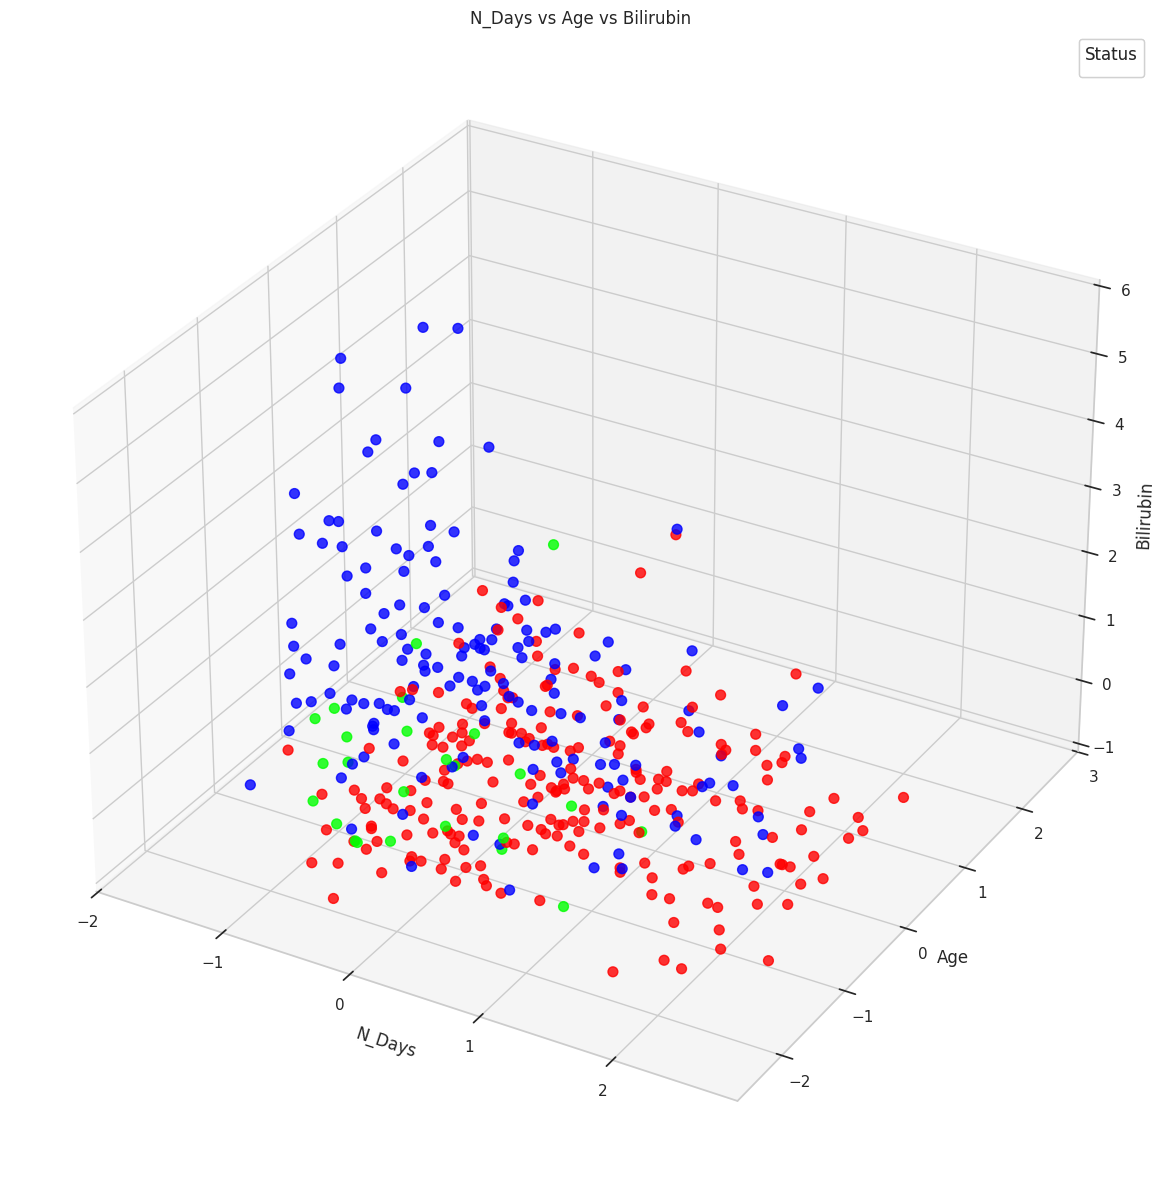

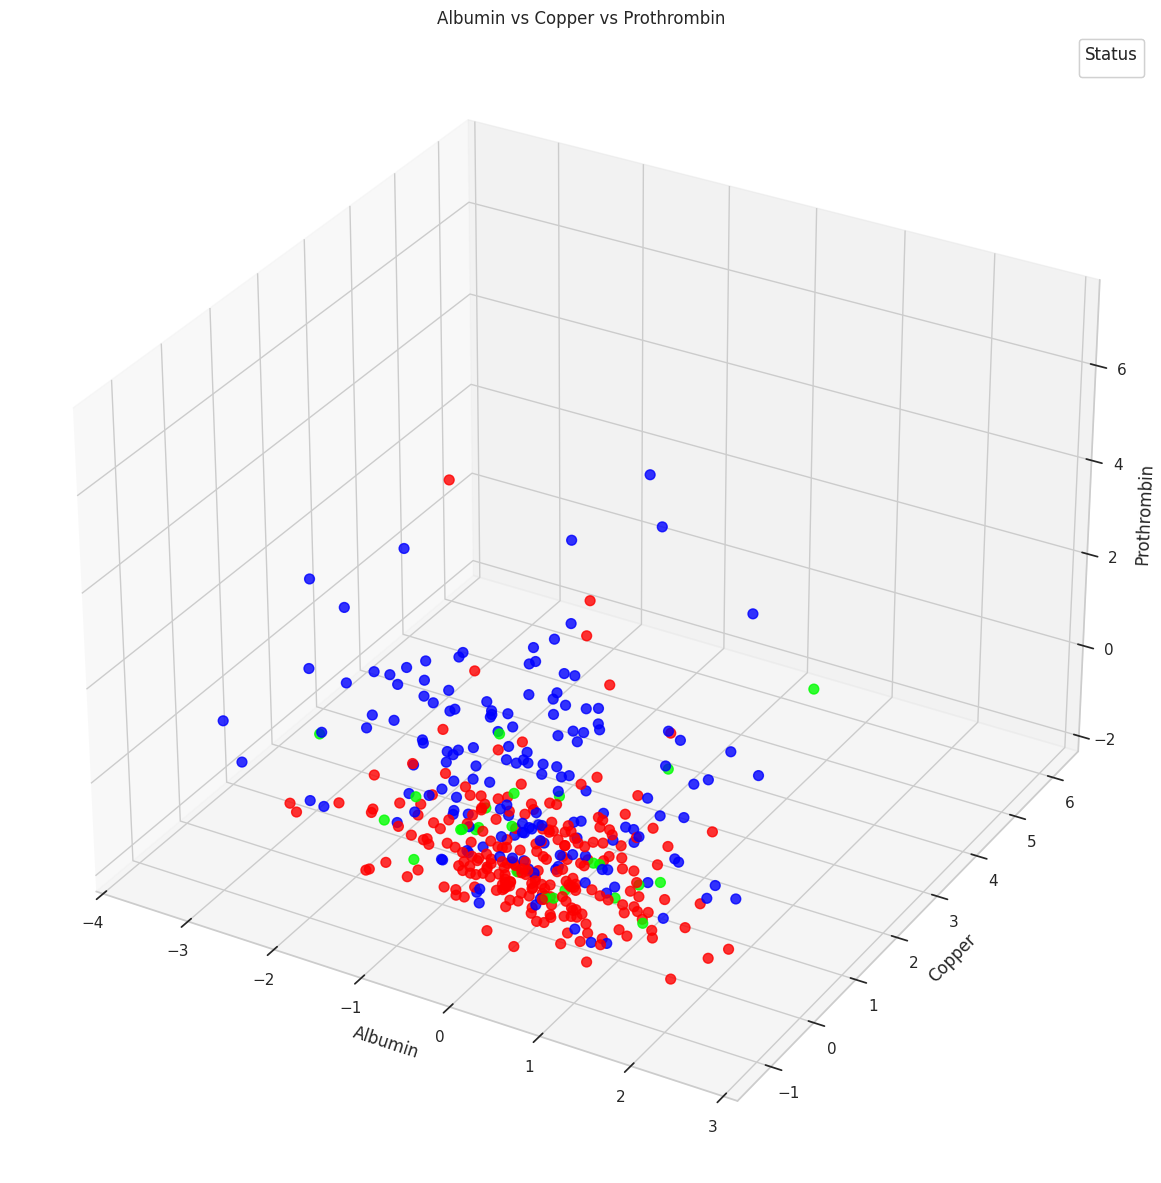

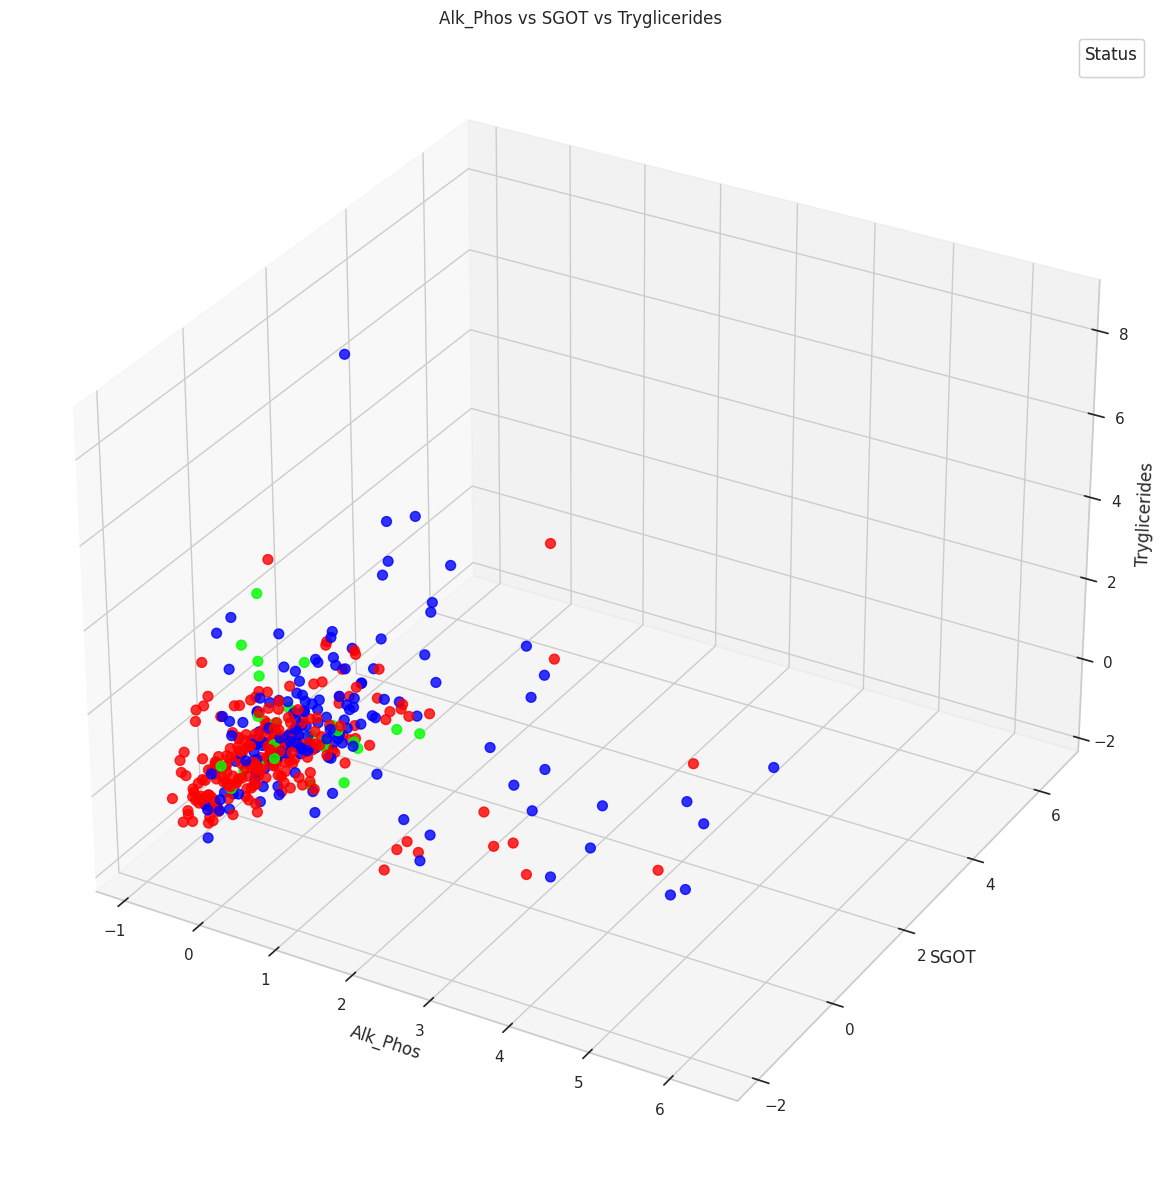

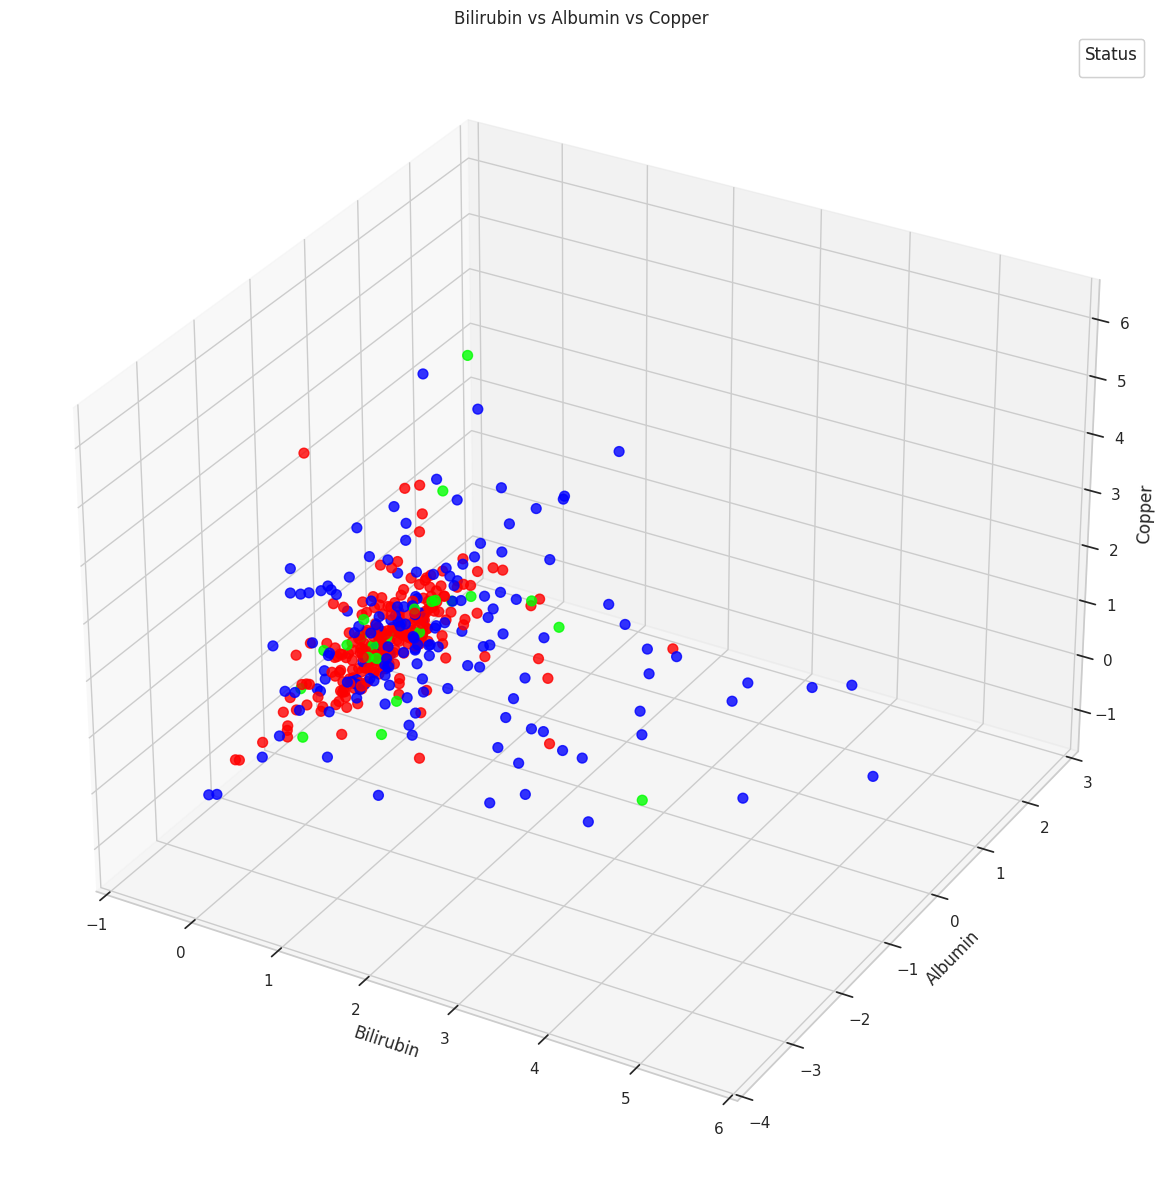

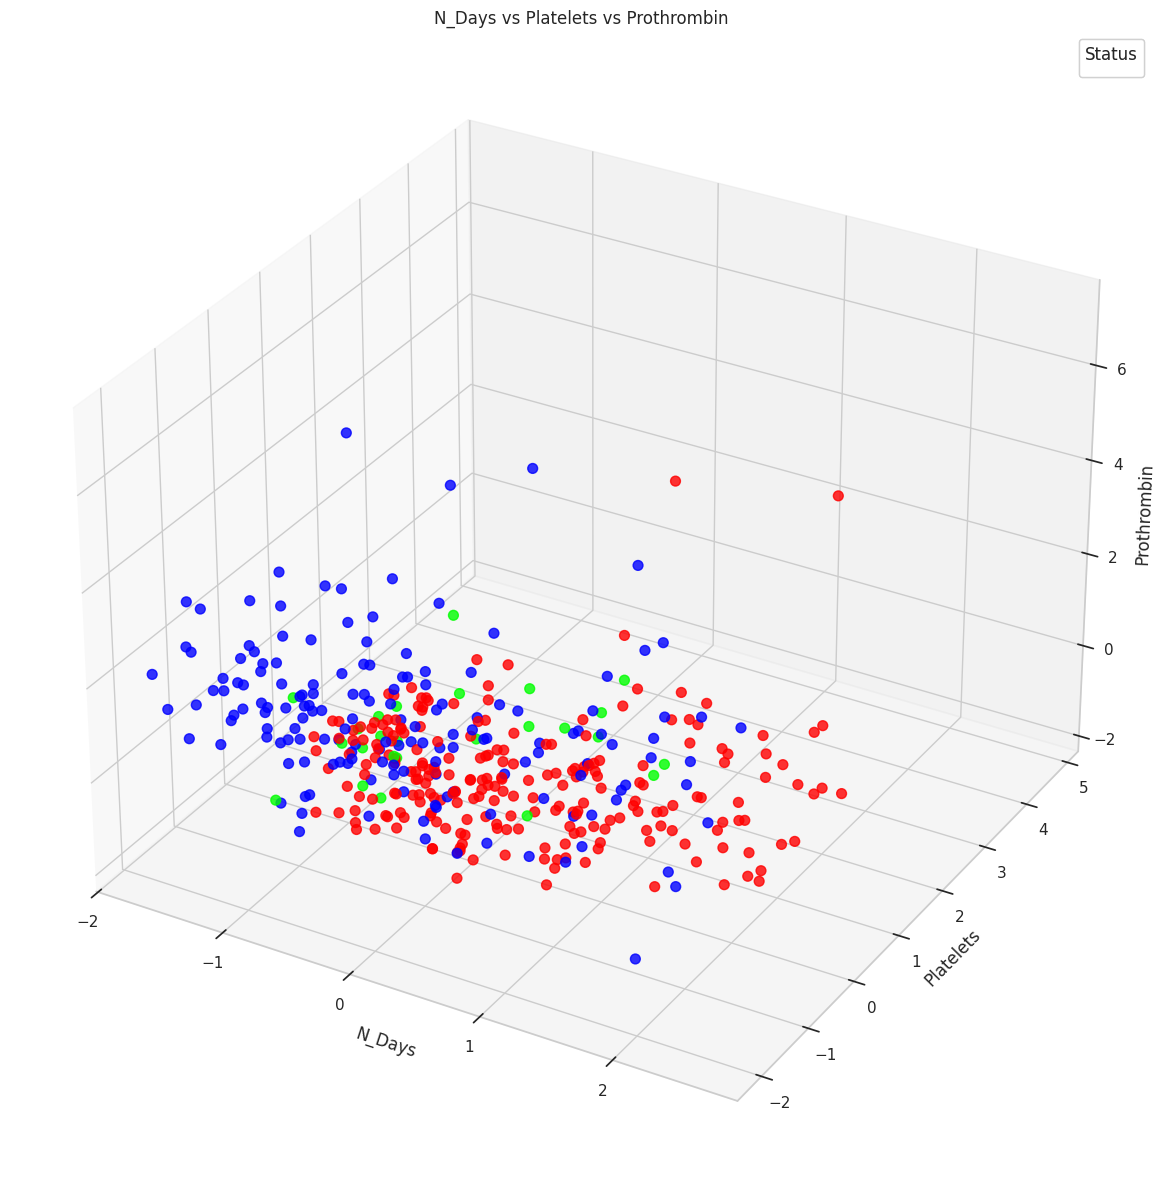

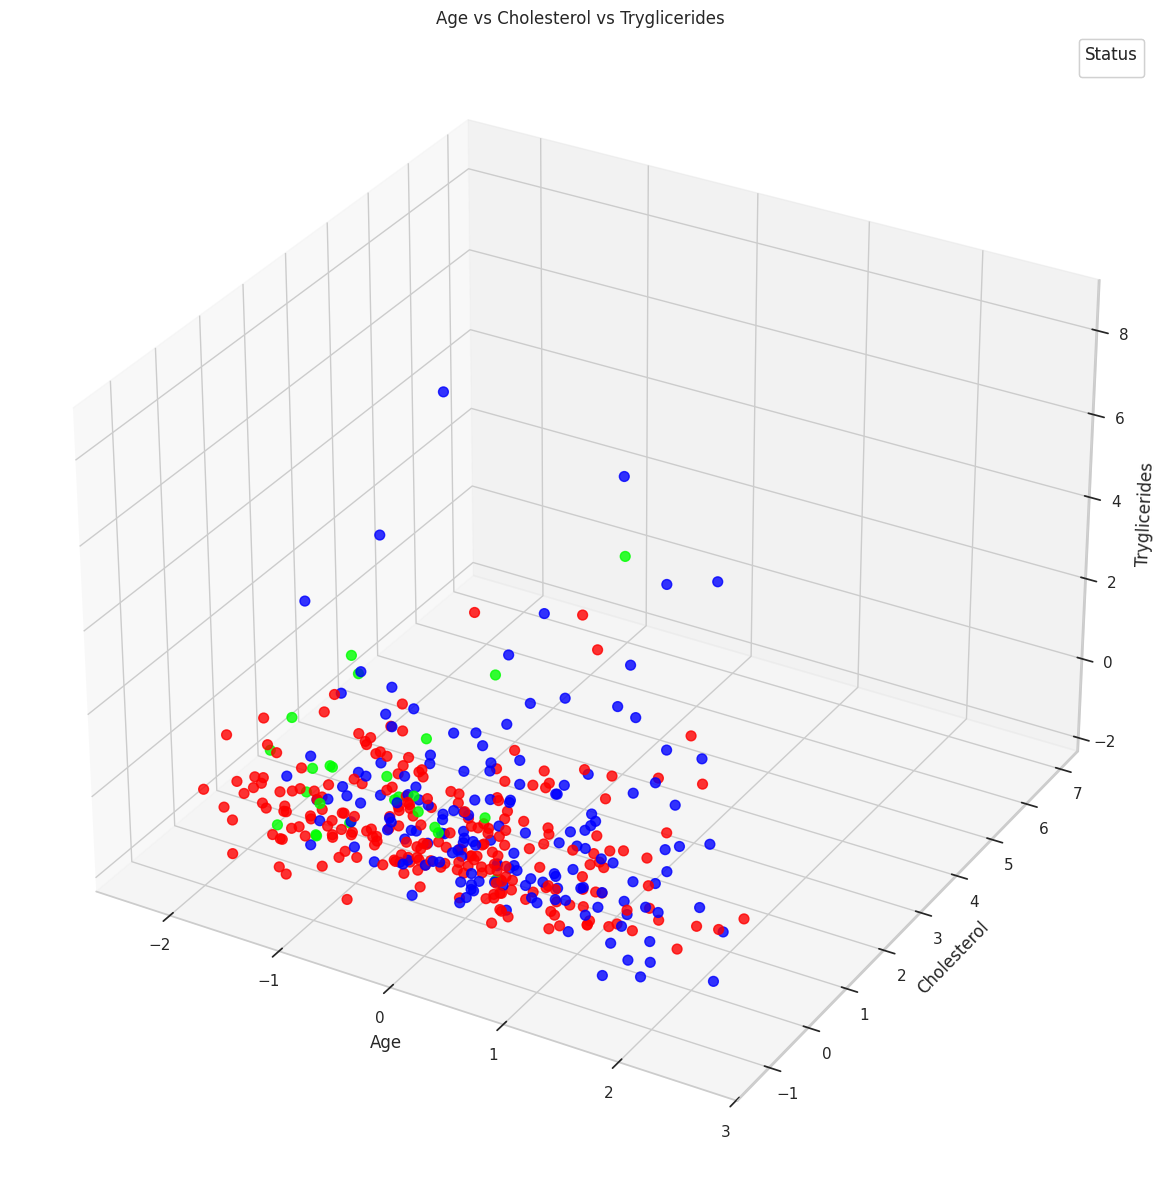

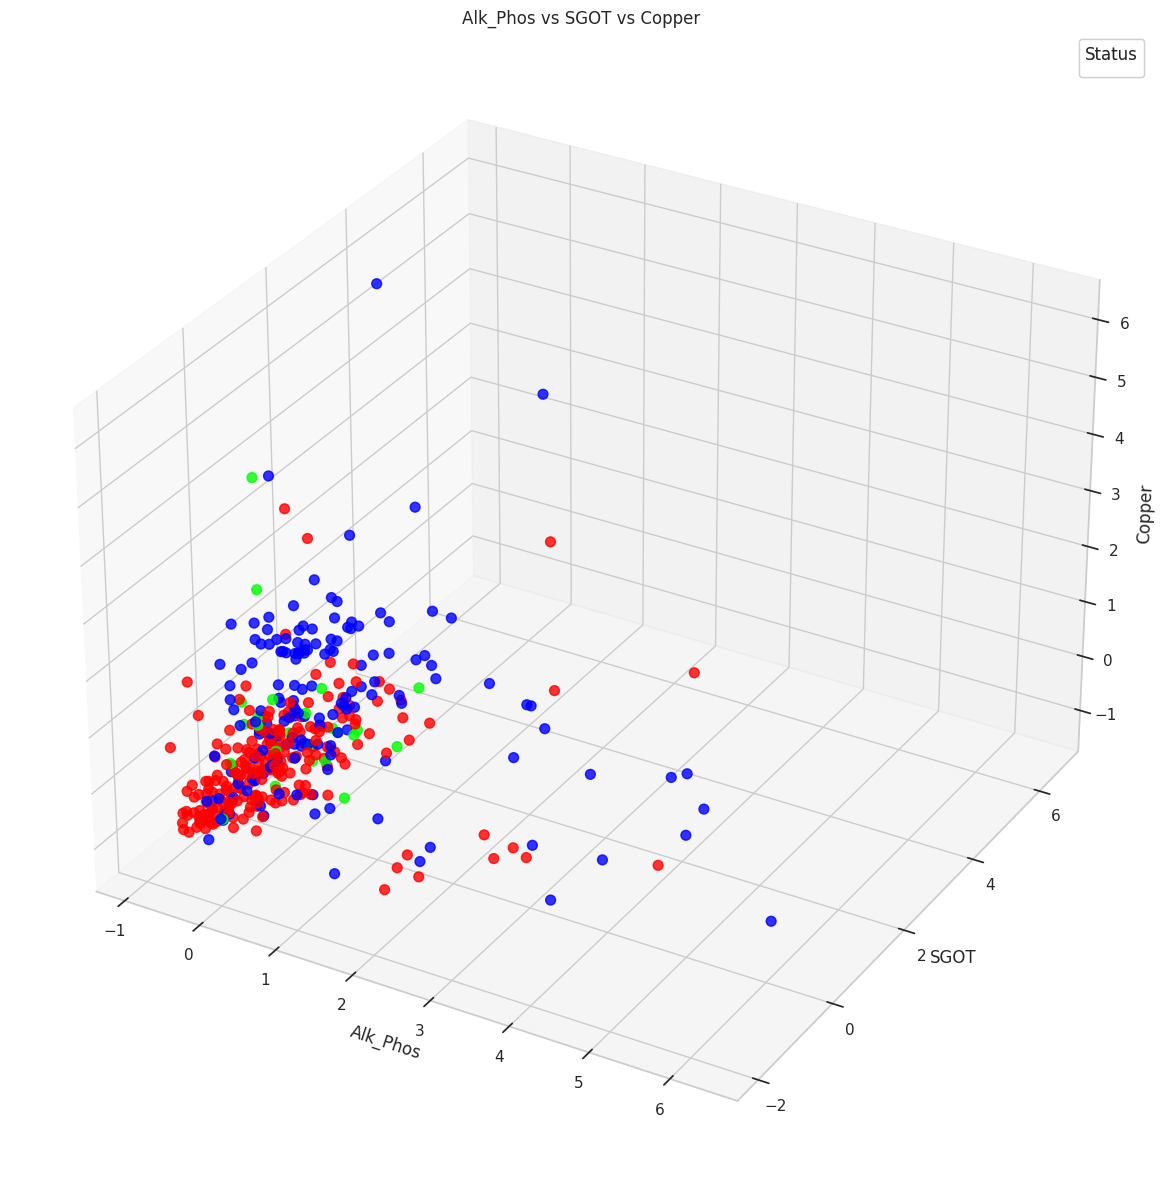

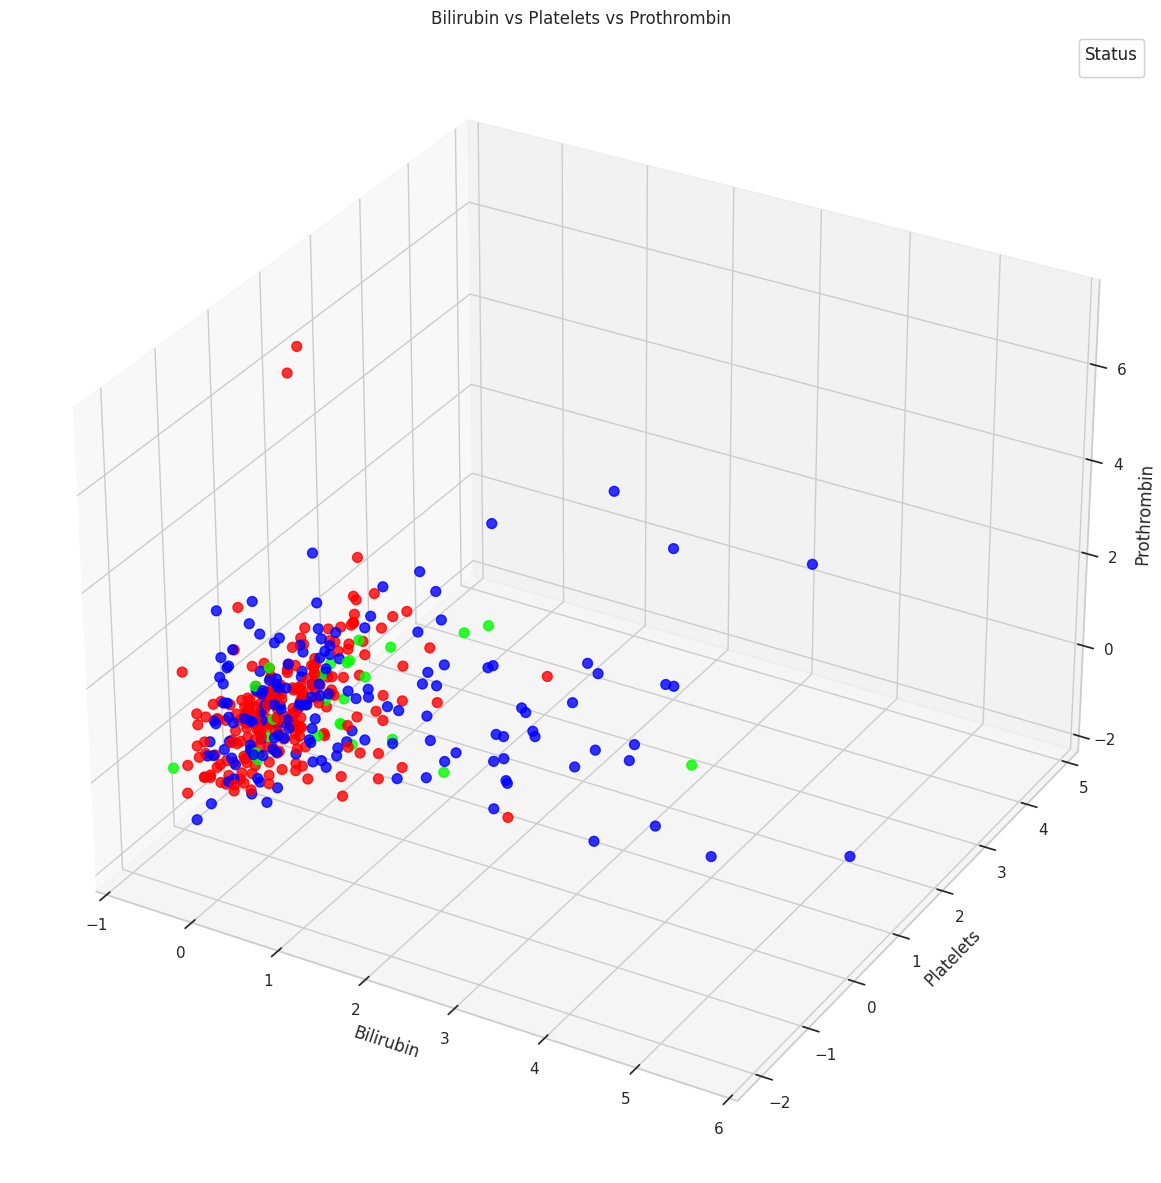

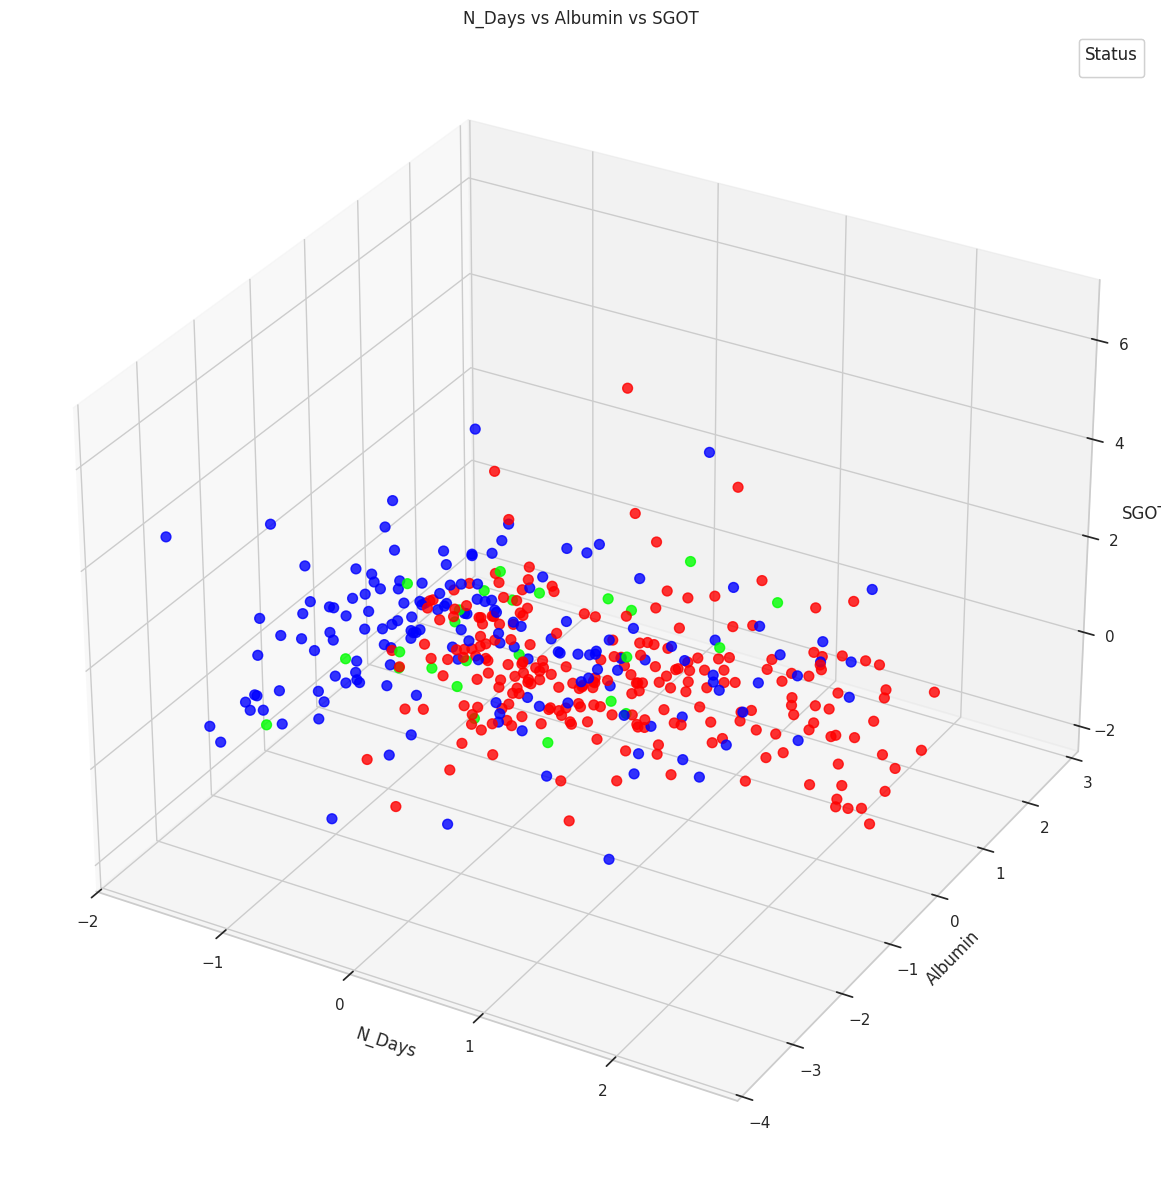

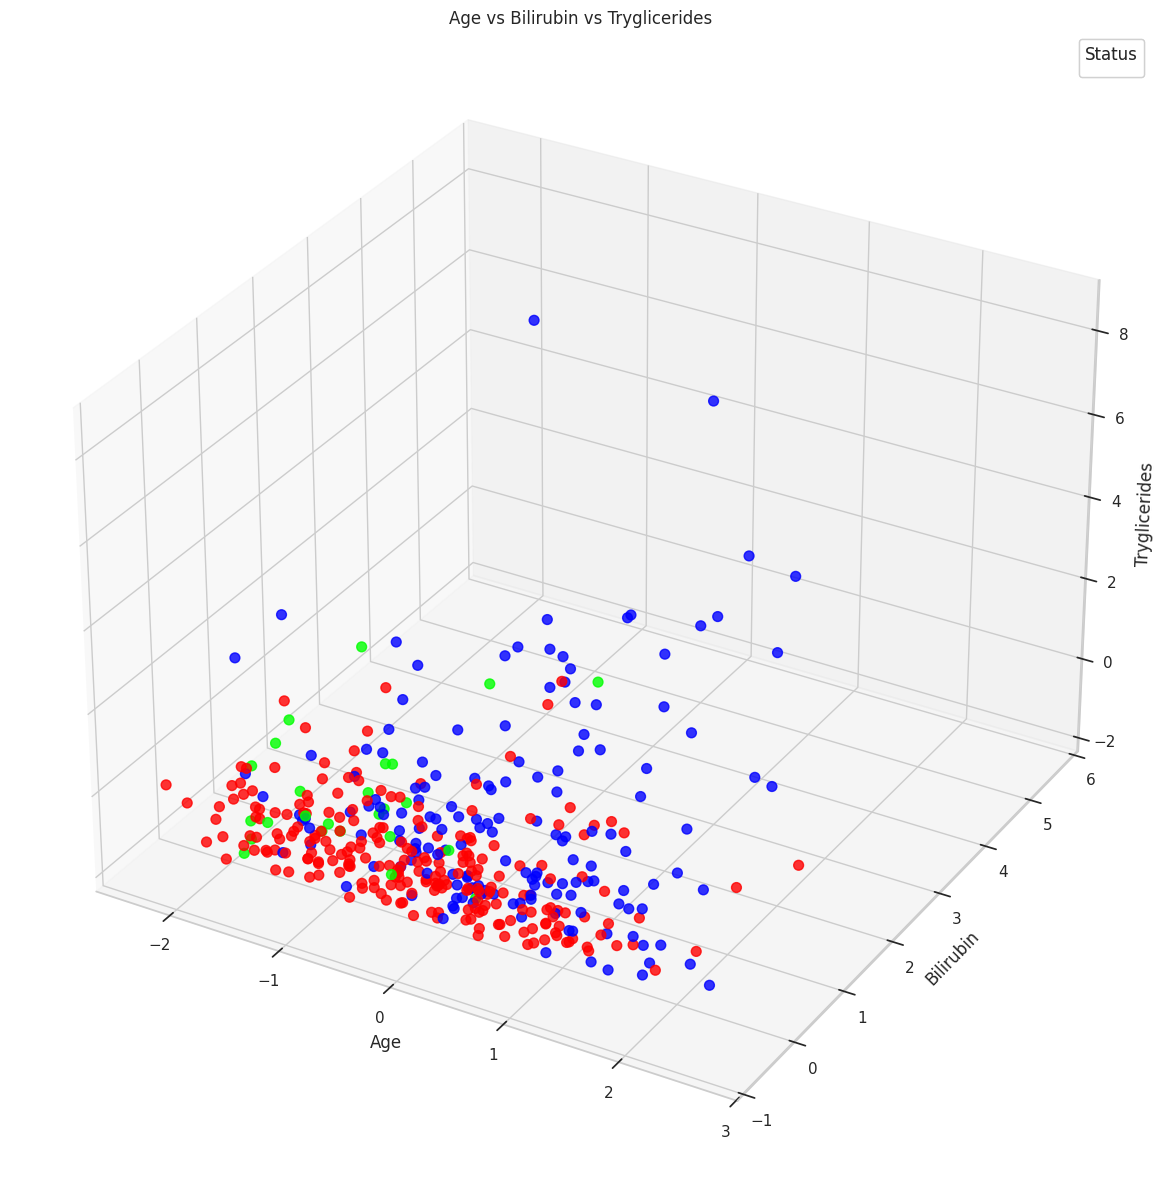

In [88]:
# Prepare data (handle missing values)
df_plot = df[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status']]

# List of combinations
combinations = [
    (['N_Days', 'Age', 'Bilirubin'], 'N_Days vs Age vs Bilirubin'),
    (['Albumin', 'Copper', 'Prothrombin'], 'Albumin vs Copper vs Prothrombin'),
    (['Alk_Phos', 'SGOT', 'Tryglicerides'], 'Alk_Phos vs SGOT vs Tryglicerides'),
    (['Bilirubin', 'Albumin', 'Copper'], 'Bilirubin vs Albumin vs Copper'),
    (['N_Days', 'Platelets', 'Prothrombin'], 'N_Days vs Platelets vs Prothrombin'),
    (['Age', 'Cholesterol', 'Tryglicerides'], 'Age vs Cholesterol vs Tryglicerides'),
    (['Alk_Phos', 'SGOT', 'Copper'], 'Alk_Phos vs SGOT vs Copper'),
    (['Bilirubin', 'Platelets', 'Prothrombin'], 'Bilirubin vs Platelets vs Prothrombin'),
    (['N_Days', 'Albumin', 'SGOT'], 'N_Days vs Albumin vs SGOT'),
    (['Age', 'Bilirubin', 'Tryglicerides'], 'Age vs Bilirubin vs Tryglicerides')
]

# Generate 3D plots
for cols, title in combinations:
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Choose 3 features to visualize
    x = df_plot[cols[0]]
    y = df_plot[cols[1]]
    z = df_plot[cols[2]]
    c = df_plot['Status']  # Color by Status (0=Censored, 1=CL, 2=Dead)

    # Map Status values to RGB colors
    color_map = {0: (1, 0, 0), 1: (0, 1, 0), 2: (0, 0, 1)}  # Red, Green, Blue
    colors = [color_map.get(stat_val, (0, 0, 0)) for stat_val in c]  # Default to black if out of range
    
    # 3D Scatter
    sc = ax.scatter(x, y, z, c=colors, s=50, alpha=0.8)
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])
    ax.set_title(title)
    
    # Add legend
    legend1 = ax.legend(*sc.legend_elements(), title="Status")
    ax.add_artist(legend1)
    
    plt.tight_layout()
    plt.show()

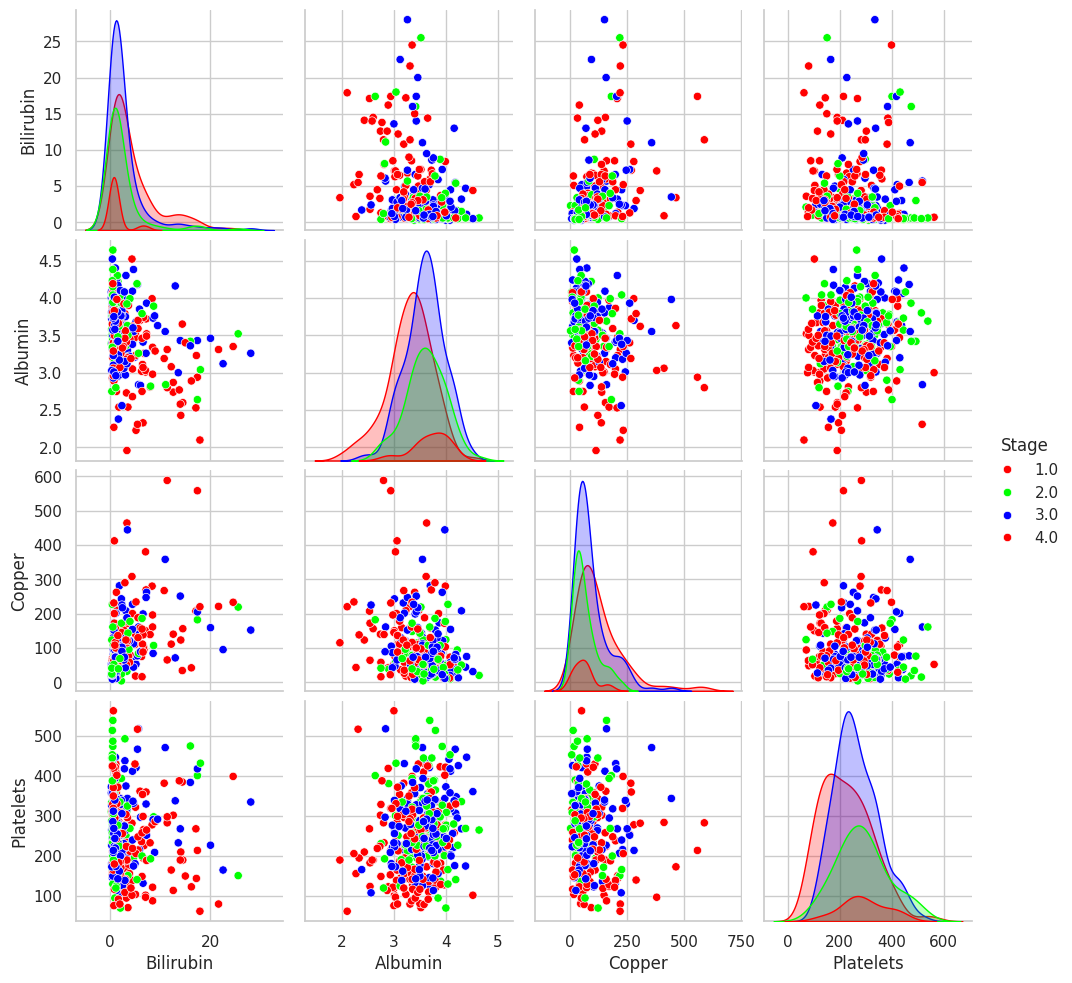

In [24]:
selected = ['Bilirubin', 'Albumin', 'Copper', 'Platelets', 'Stage']
sns.pairplot(data_copy[selected], hue='Stage', palette=[(1, 0, 0), (0, 1, 0), (0, 0, 1)])
plt.show()


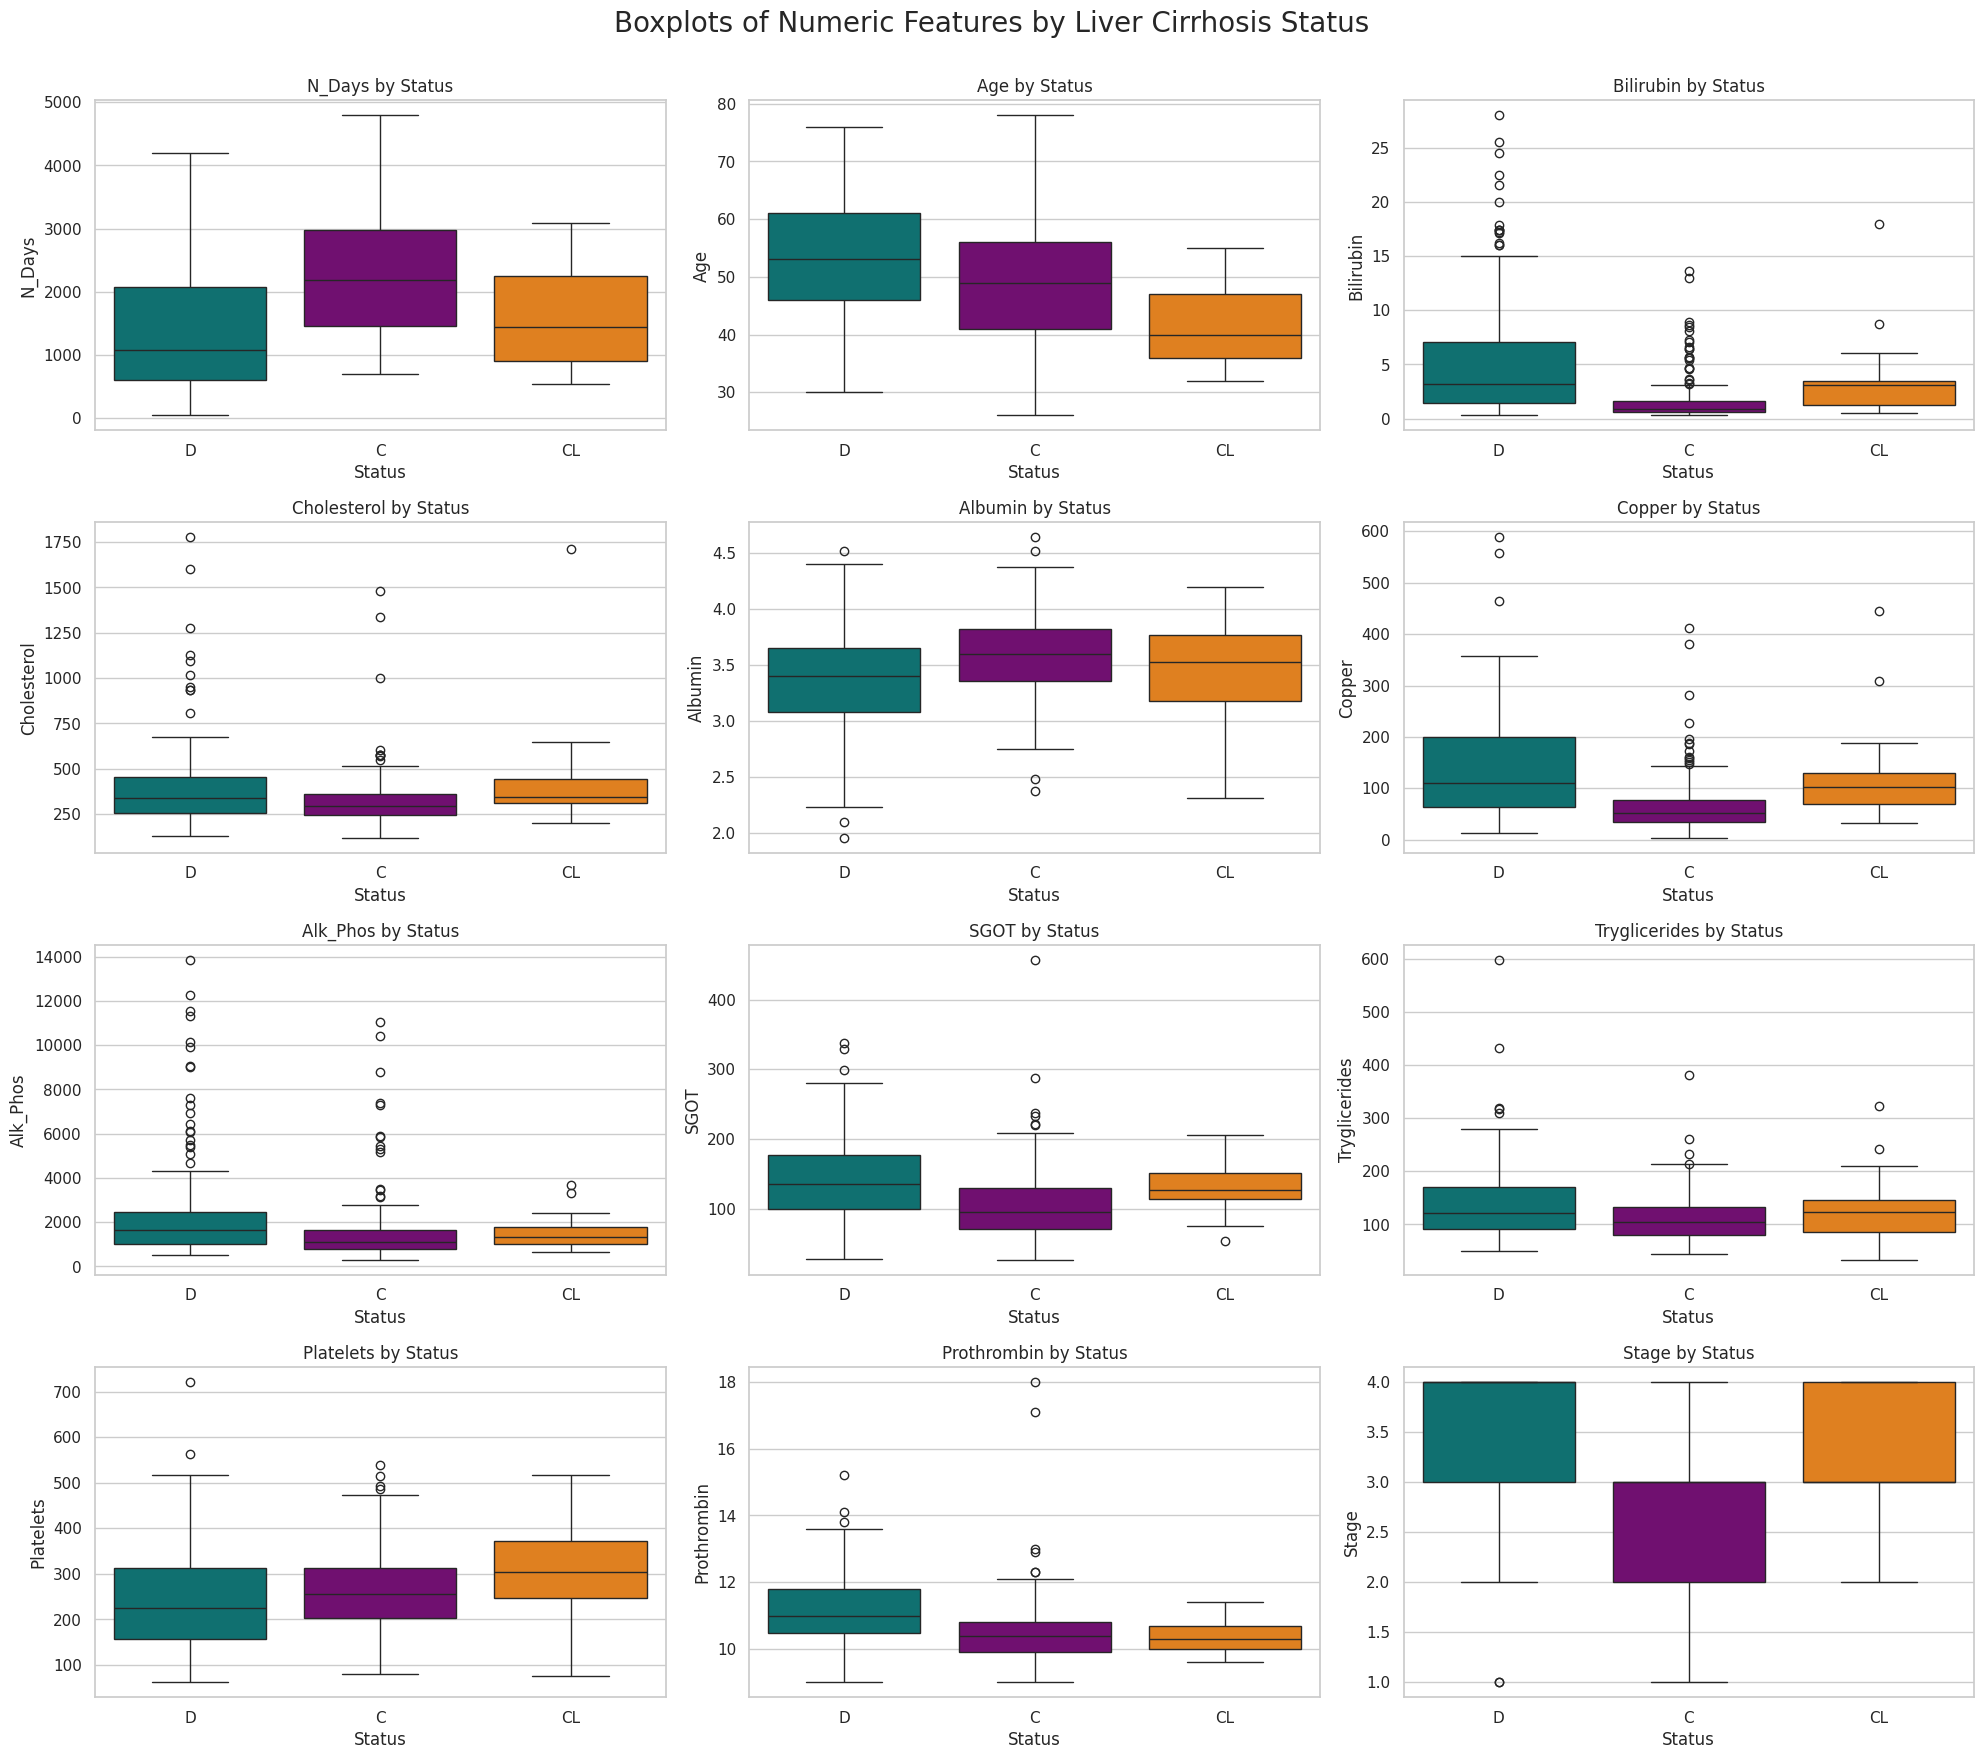

In [25]:
# Plot boxplots of numeric features grouped by 'Status'
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_num):
    plt.subplot(6, 3, i + 1)
    sns.boxplot(data=df_num, x=data_copy['Status'], y=col, palette=[(0, 0.5, 0.5), (0.5, 0, 0.5), (1, 0.5, 0)])
    plt.title(f'{col} by Status')
    plt.tight_layout()

plt.suptitle('Boxplots of Numeric Features by Liver Cirrhosis Status', fontsize=20, y=1.02)
plt.show()

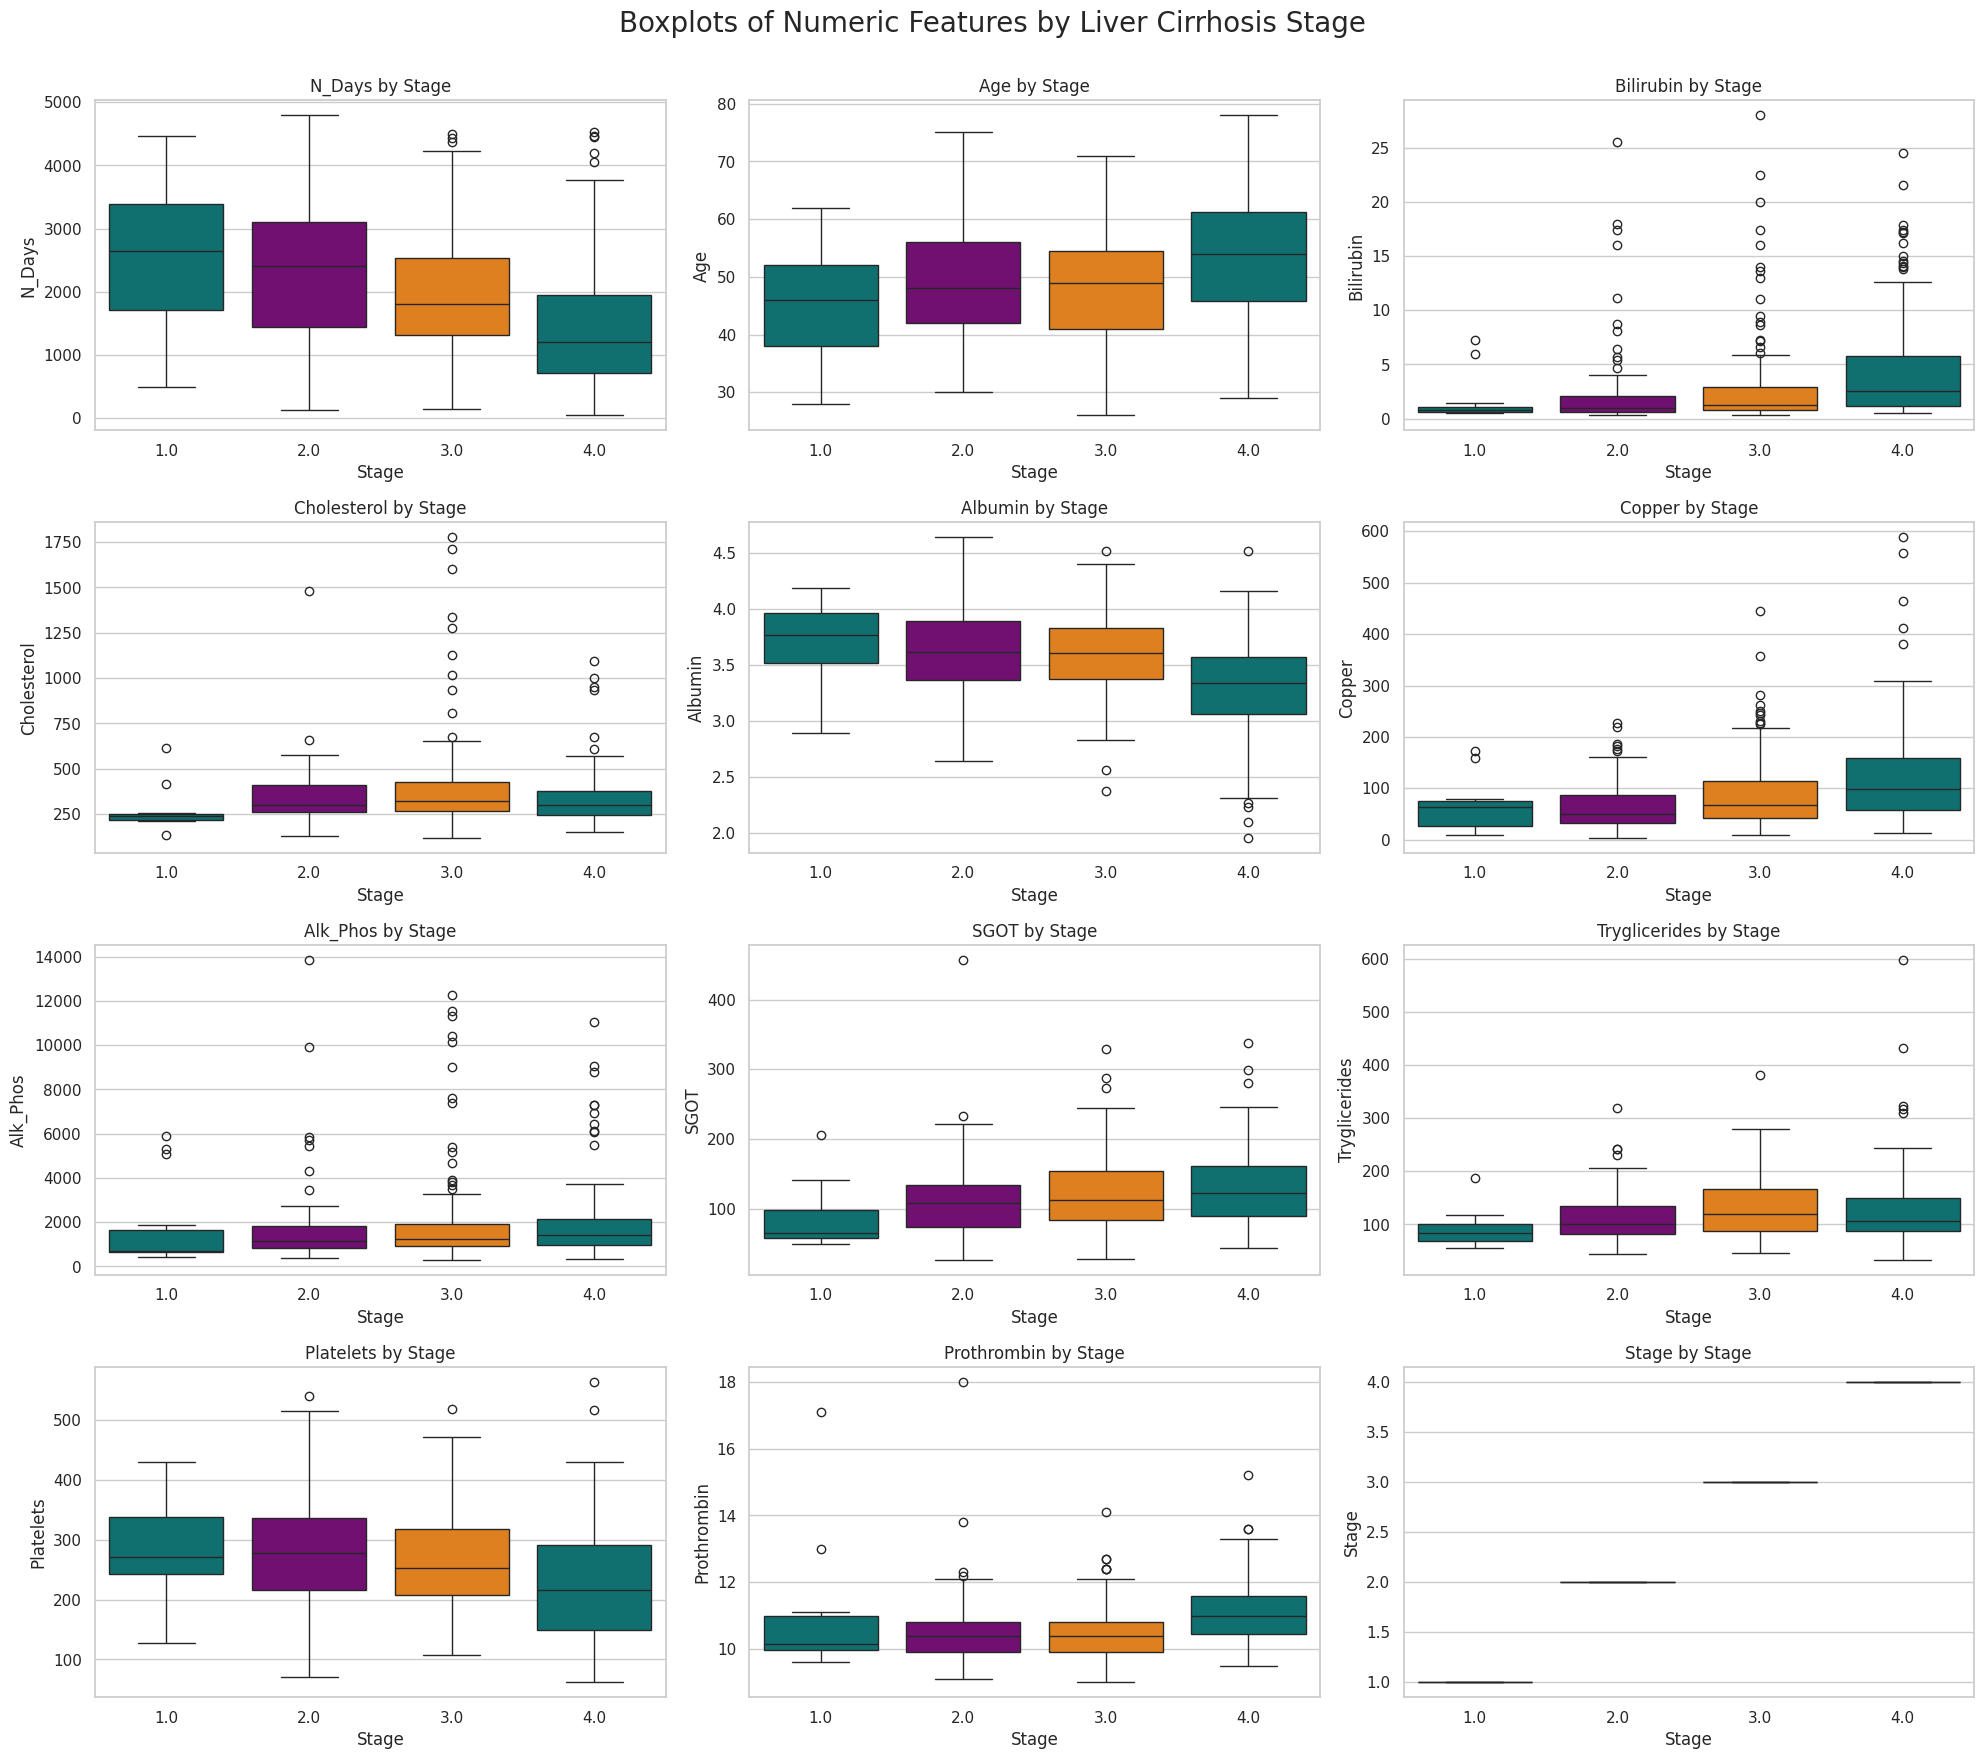

In [26]:
# Plot boxplots of numeric features grouped by 'Stage'
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_num):
    plt.subplot(6, 3, i + 1)
    sns.boxplot(data=df_num, x='Stage', y=col, palette=[(0, 0.5, 0.5), (0.5, 0, 0.5), (1, 0.5, 0)])
    plt.title(f'{col} by Stage')
    plt.tight_layout()

plt.suptitle('Boxplots of Numeric Features by Liver Cirrhosis Stage', fontsize=20, y=1.02)
plt.show()

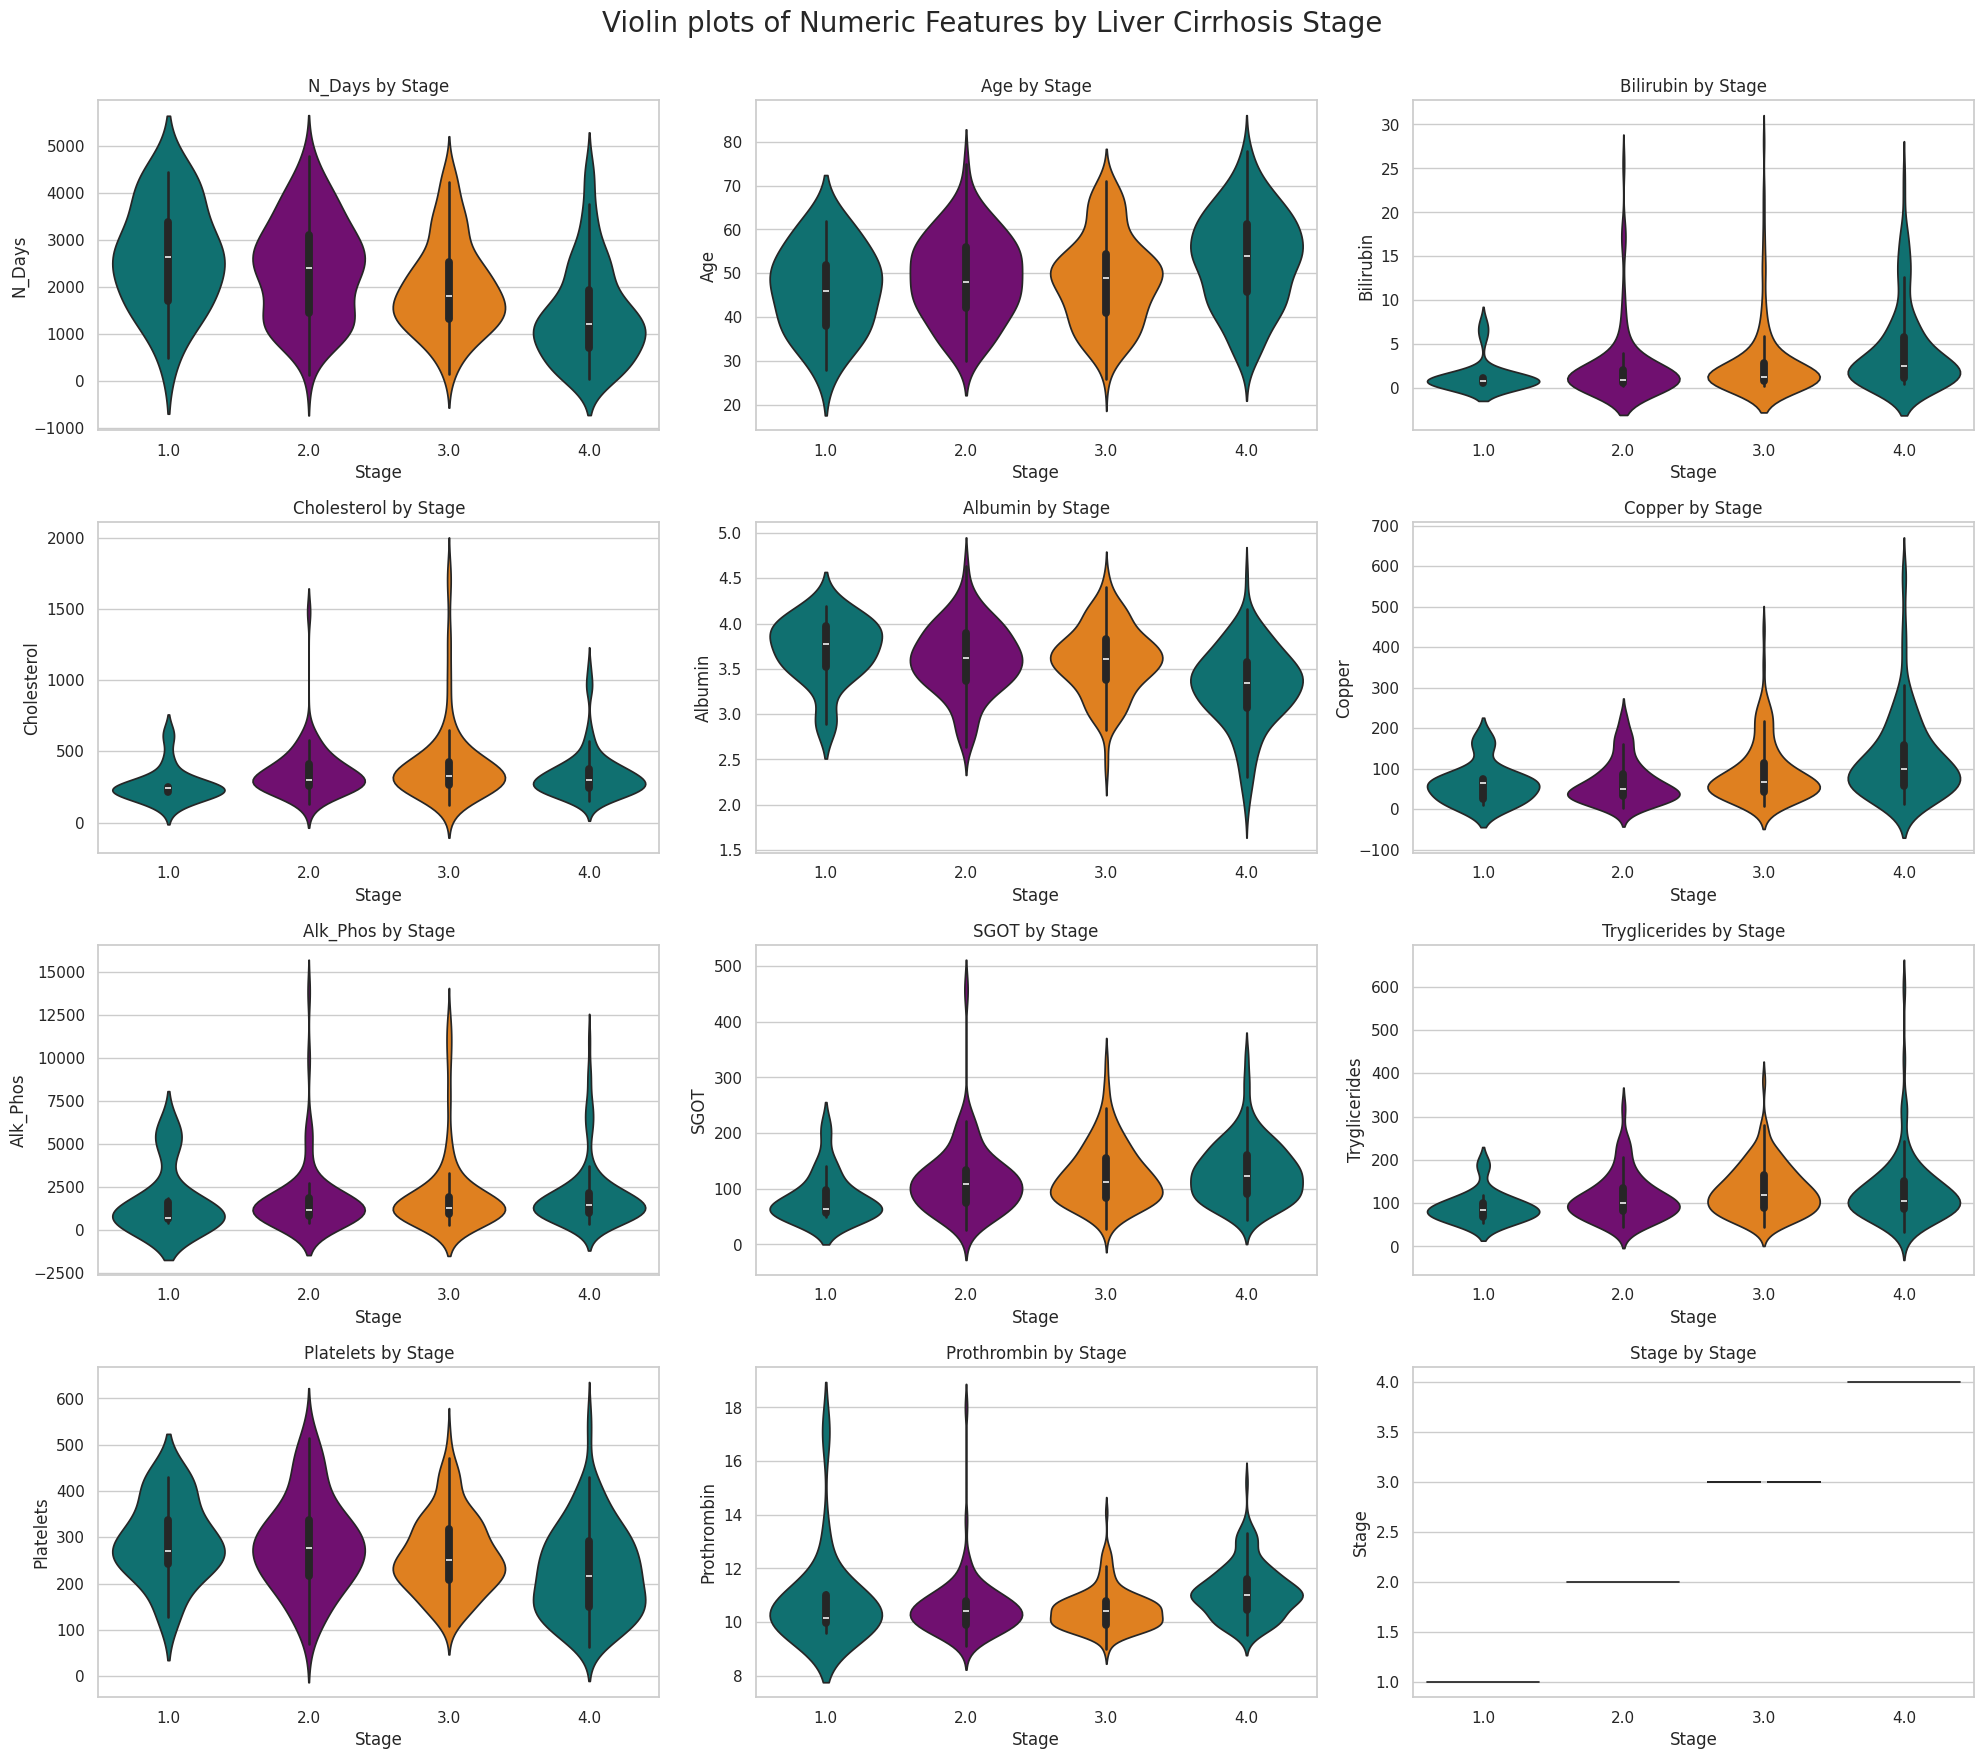

In [27]:
# Plot vioolin plots of numeric features grouped by 'Stage'
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_num):
    plt.subplot(6, 3, i + 1)
    sns.violinplot(data=df_num, x='Stage', y=col, palette=[(0, 0.5, 0.5), (0.5, 0, 0.5), (1, 0.5, 0)])
    plt.title(f'{col} by Stage')
    plt.tight_layout()

plt.suptitle('Violin plots of Numeric Features by Liver Cirrhosis Stage', fontsize=20, y=1.02)
plt.show()


# Extracting Outliers from the dataset

In [28]:
df_num.head()

N_Days  Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     400   58       14.5        261.0     2.60   156.0    1718.0  137.95   
1    4500   56        1.1        302.0     4.14    54.0    7394.8  113.52   
2    1012   70        1.4        176.0     3.48   210.0     516.0   96.10   
3    1925   54        1.8        244.0     2.54    64.0    6121.8   60.63   
4    1504   38        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [29]:
df_num_copy = df_num.copy()
df_num_copy.head()

N_Days  Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     400   58       14.5        261.0     2.60   156.0    1718.0  137.95   
1    4500   56        1.1        302.0     4.14    54.0    7394.8  113.52   
2    1012   70        1.4        176.0     3.48   210.0     516.0   96.10   
3    1925   54        1.8        244.0     2.54    64.0    6121.8   60.63   
4    1504   38        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [30]:
# Identifying extreme values in the dataset
skewed_cols = ['Bilirubin', 'Copper', 'SGOT', 'Cholesterol', 'Alk_Phos', 'Tryglicerides', 'Prothrombin', 'Platelets']
outlier_mask = pd.DataFrame(False, index=df_num_copy.index, columns=skewed_cols)
for col in skewed_cols:
    Q1 = df_num_copy[col].quantile(0.25)
    Q3 = df_num_copy[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask[col] = (df_num_copy[col] < lower_bound) | (df_num_copy[col] > upper_bound)
    # print(f"\nOutliers in {col}: {df_num_copy[outlier_mask[col]].shape[0]} rows")

In [31]:
# Create DataFrame with outliers (rows where any skewed column has an outlier)
outlier_rows = outlier_mask.any(axis=1)
df_outliers = df_num_copy[outlier_rows].copy()
# print(f"\nOutlier DataFrame Shape: {df_outliers.shape}")

In [32]:
df_outliers.head()

N_Days  Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     400   58       14.5        261.0     2.60   156.0    1718.0  137.95   
1    4500   56        1.1        302.0     4.14    54.0    7394.8  113.52   
3    1925   54        1.8        244.0     2.54    64.0    6121.8   60.63   
7    2466   53        0.3        280.0     4.00    52.0    4651.2   28.38   
9      51   70       12.6        200.0     2.74   140.0     918.0  147.25   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
3           92.0      183.0         10.3    4.0  
7          189.0      373.0         11.0    3.0  
9          143.0      302.0         11.5    4.0

In [33]:
df_outliers.describe()

N_Days        Age   Bilirubin  Cholesterol     Albumin  \
count   113.000000  113.00000  113.000000    86.000000  113.000000   
mean   1672.053097   50.79646    7.408850   497.720930    3.365133   
std    1337.952900    9.88068    6.533547   366.619009    0.459938   
min      41.000000   30.00000    0.300000   151.000000    2.100000   
25%     732.000000   44.00000    1.800000   259.250000    3.060000   
50%    1302.000000   51.00000    5.700000   359.500000    3.400000   
75%    2386.000000   58.00000   11.400000   595.500000    3.700000   
max    4795.000000   78.00000   28.000000  1775.000000    4.220000   

           Copper      Alk_Phos        SGOT  Tryglicerides   Platelets  \
count   94.000000     94.000000   94.000000      86.000000  110.000000   
mean   154.308511   3640.059574  142.793404     166.732558  274.118182   
std    115.827275   3240.034635   73.938616      86.943988  122.108294   
min     10.000000    559.000000   26.350000      49.000000   62.000000   
25%     73.250000   1154.500000   84.395000     108.750000  190.750000   
50%    122.500000   2158.000000  128.955000     152.000000  274.000000   
75%    208.500000   5421.650000  181.162500     194.750000  344.000000   
max    588.000000  13862.400000  457.250000     598.000000  721.000000   

       Prothrombin       Stage  
count   112.000000  112.000000  
mean     11.338393    3.187500  
std       1.437418    0.895748  
min       9.500000    1.000000  
25%      10.400000    3.000000  
50%      11.000000    3.000000  
75%      11.925000    4.000000  
max      18.000000    4.000000

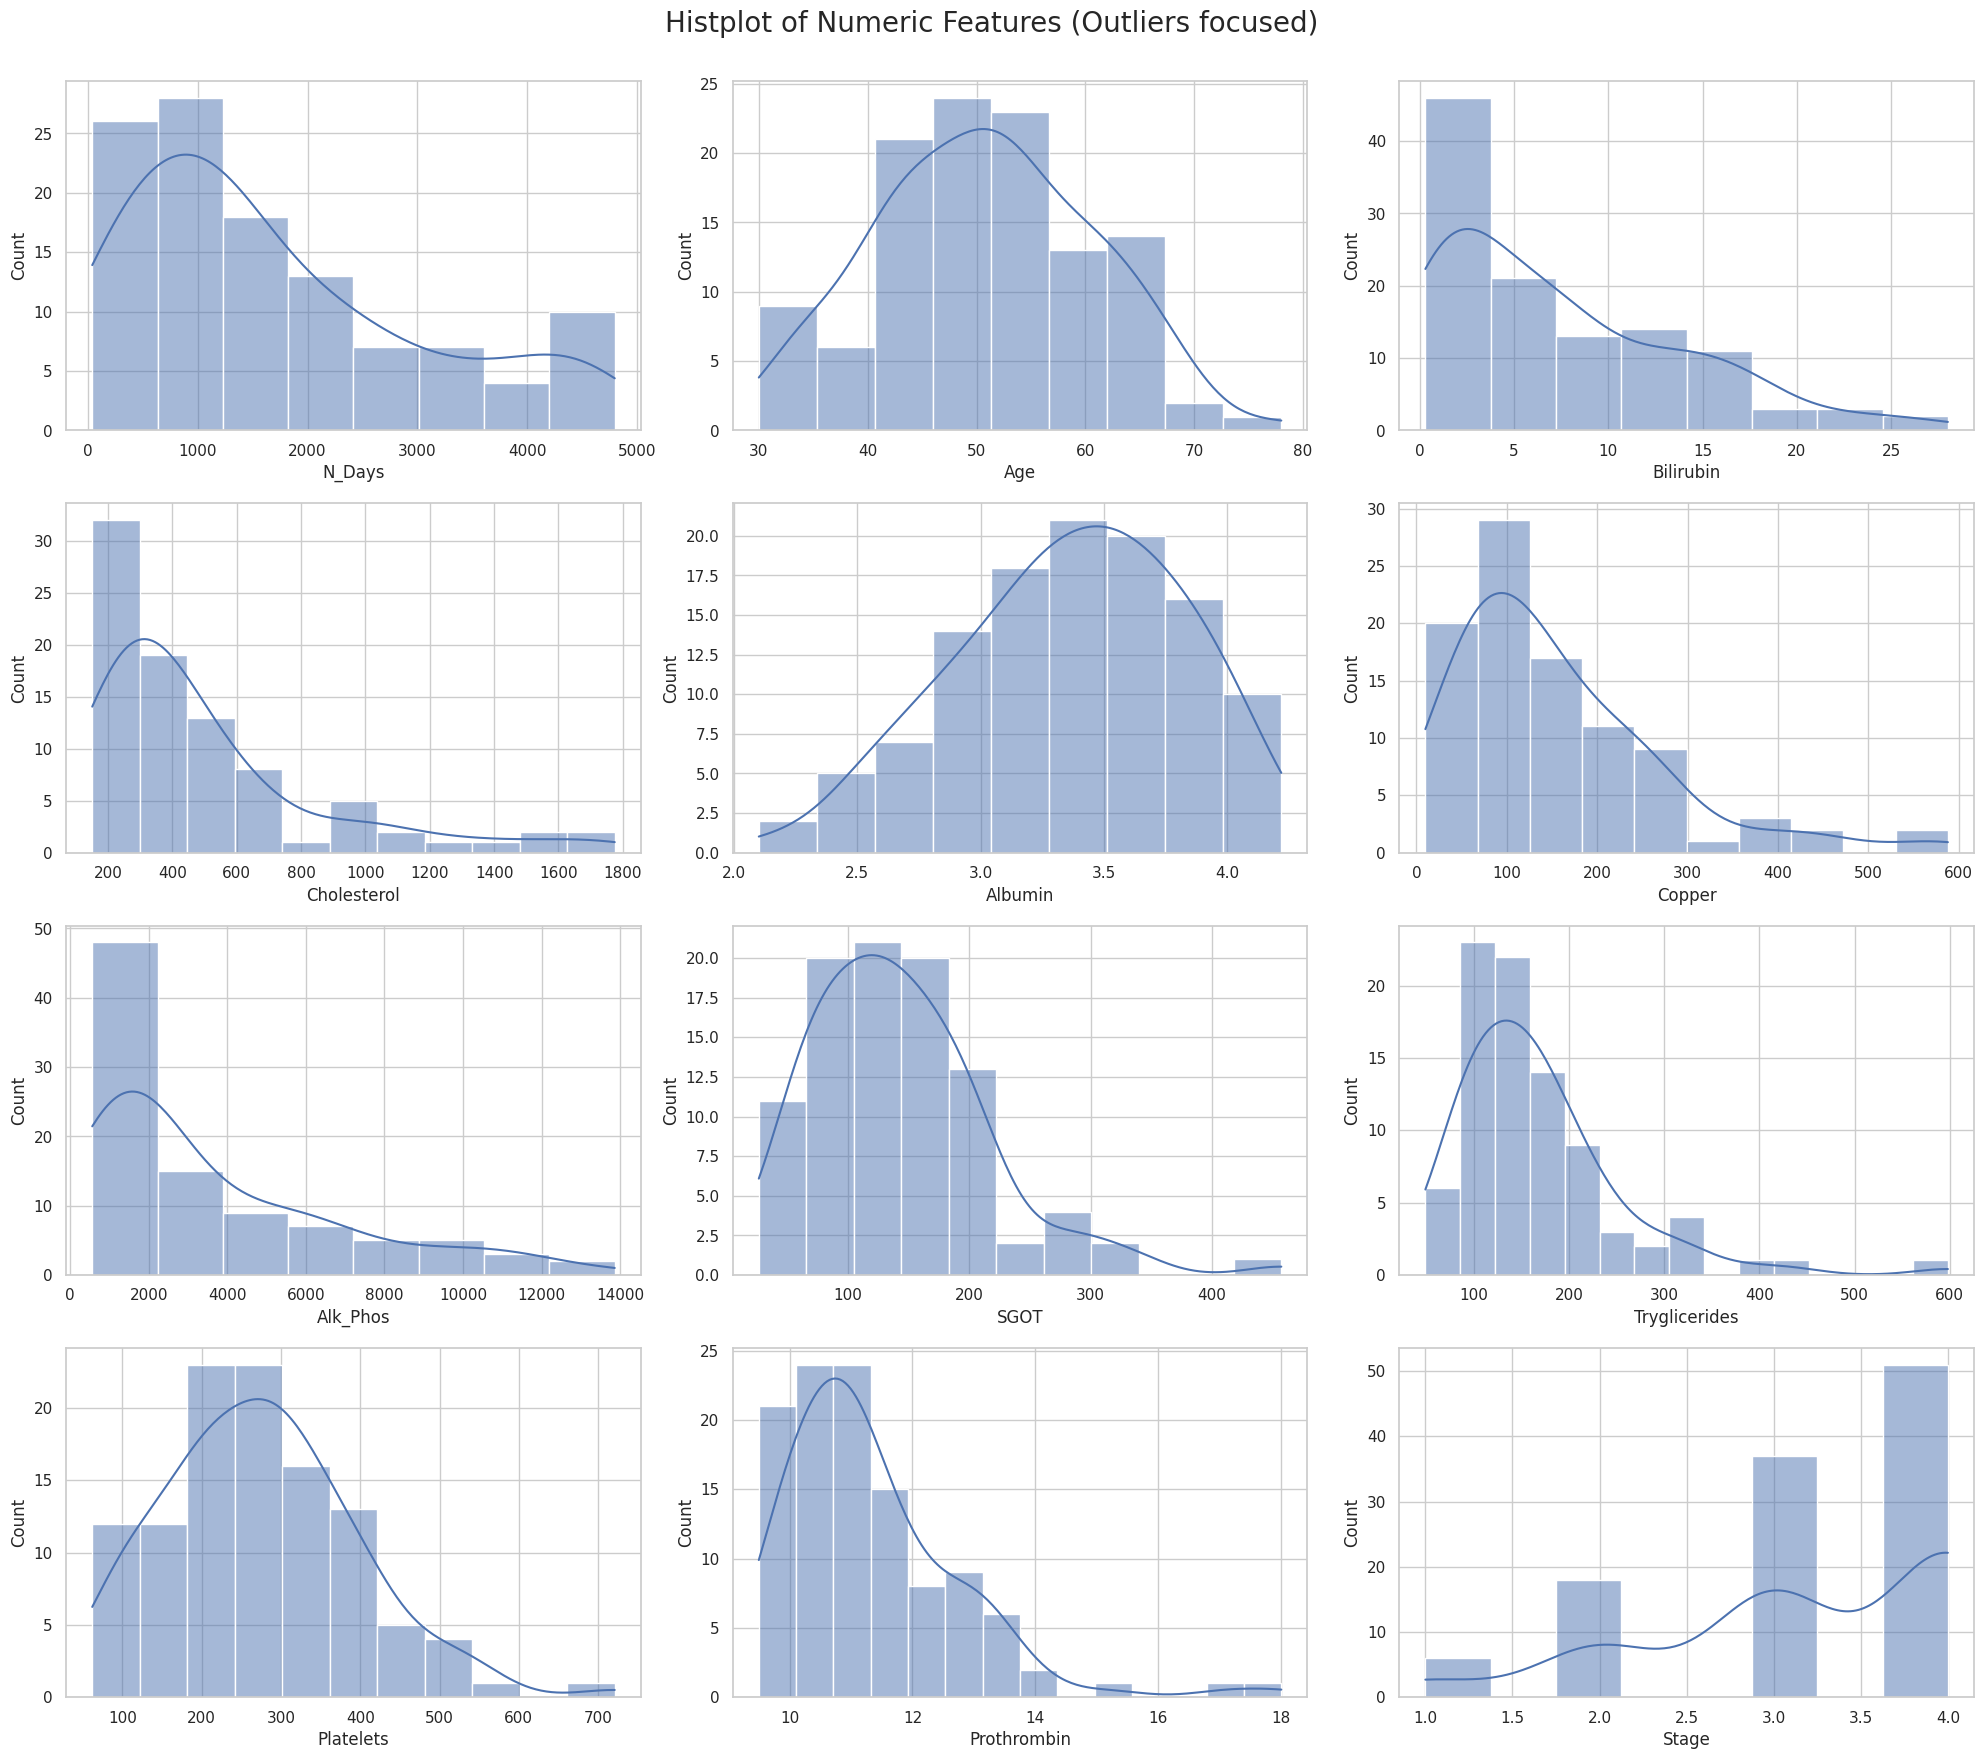

In [34]:
# Plot Histograms of numeric features
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_outliers):
    plt.subplot(6, 3, i + 1)
    sns.histplot(data=df_outliers, x=col, palette=[(0, 0.5, 0.5), (0.5, 0, 0.5), (1, 0.5, 0)], kde=True)
    # plt.title(f'{col} by Stage')
    plt.tight_layout()

plt.suptitle('Histplot of Numeric Features (Outliers focused)', fontsize=20, y=1.02)
plt.show()

In [35]:
# Create copied DataFrame without outliers
df_no_outliers = df_num_copy[~outlier_rows].copy()
print(f"No-Outlier DataFrame Shape: {df_no_outliers.shape}")

No-Outlier DataFrame Shape: (305, 12)


In [36]:
df_no_outliers.head()

N_Days  Age  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
2    1012   70        1.4        176.0     3.48   210.0     516.0   96.10   
4    1504   38        3.4        279.0     3.53   143.0     671.0  113.15   
5    2503   66        0.8        248.0     3.98    50.0     944.0   93.00   
6    1832   55        1.0        322.0     4.09    52.0     824.0   60.45   
8    2400   42        3.2        562.0     3.08    79.0    2276.0  144.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
2           55.0      151.0         12.0    4.0  
4           72.0      136.0         10.9    3.0  
5           63.0        NaN         11.0    3.0  
6          213.0      204.0          9.7    3.0  
8           88.0      251.0         11.0    2.0

In [37]:
df_no_outliers.describe()

N_Days         Age   Bilirubin  Cholesterol     Albumin  \
count   305.000000  305.000000  305.000000   198.000000  305.000000   
mean   2008.822951   50.108197    1.669180   313.823232    3.546459   
std     991.778165   10.692384    1.408889    94.853101    0.401095   
min      41.000000   26.000000    0.300000   120.000000    1.960000   
25%    1236.000000   42.000000    0.700000   248.000000    3.350000   
50%    1882.000000   51.000000    1.100000   299.000000    3.570000   
75%    2644.000000   58.000000    2.100000   372.750000    3.800000   
max    4365.000000   76.000000    6.800000   604.000000    4.640000   

           Copper     Alk_Phos        SGOT  Tryglicerides   Platelets  \
count  216.000000   218.000000  218.000000     196.000000  297.000000   
mean    72.990741  1267.995413  113.830275     106.260204  250.693603   
std     52.122574   603.054907   44.839421      41.233527   87.299831   
min      4.000000   289.000000   41.850000      33.000000   76.000000   
25%     37.750000   816.250000   79.050000      76.000000  183.000000   
50%     58.000000  1115.000000  107.725000     100.000000  246.000000   
75%     91.750000  1625.000000  137.950000     128.000000  311.000000   
max    243.000000  3472.000000  246.450000     242.000000  493.000000   

       Prothrombin       Stage  
count   304.000000  300.000000  
mean     10.508224    2.963333  
std       0.698205    0.870545  
min       9.000000    1.000000  
25%      10.000000    2.000000  
50%      10.450000    3.000000  
75%      11.000000    4.000000  
max      12.700000    4.000000

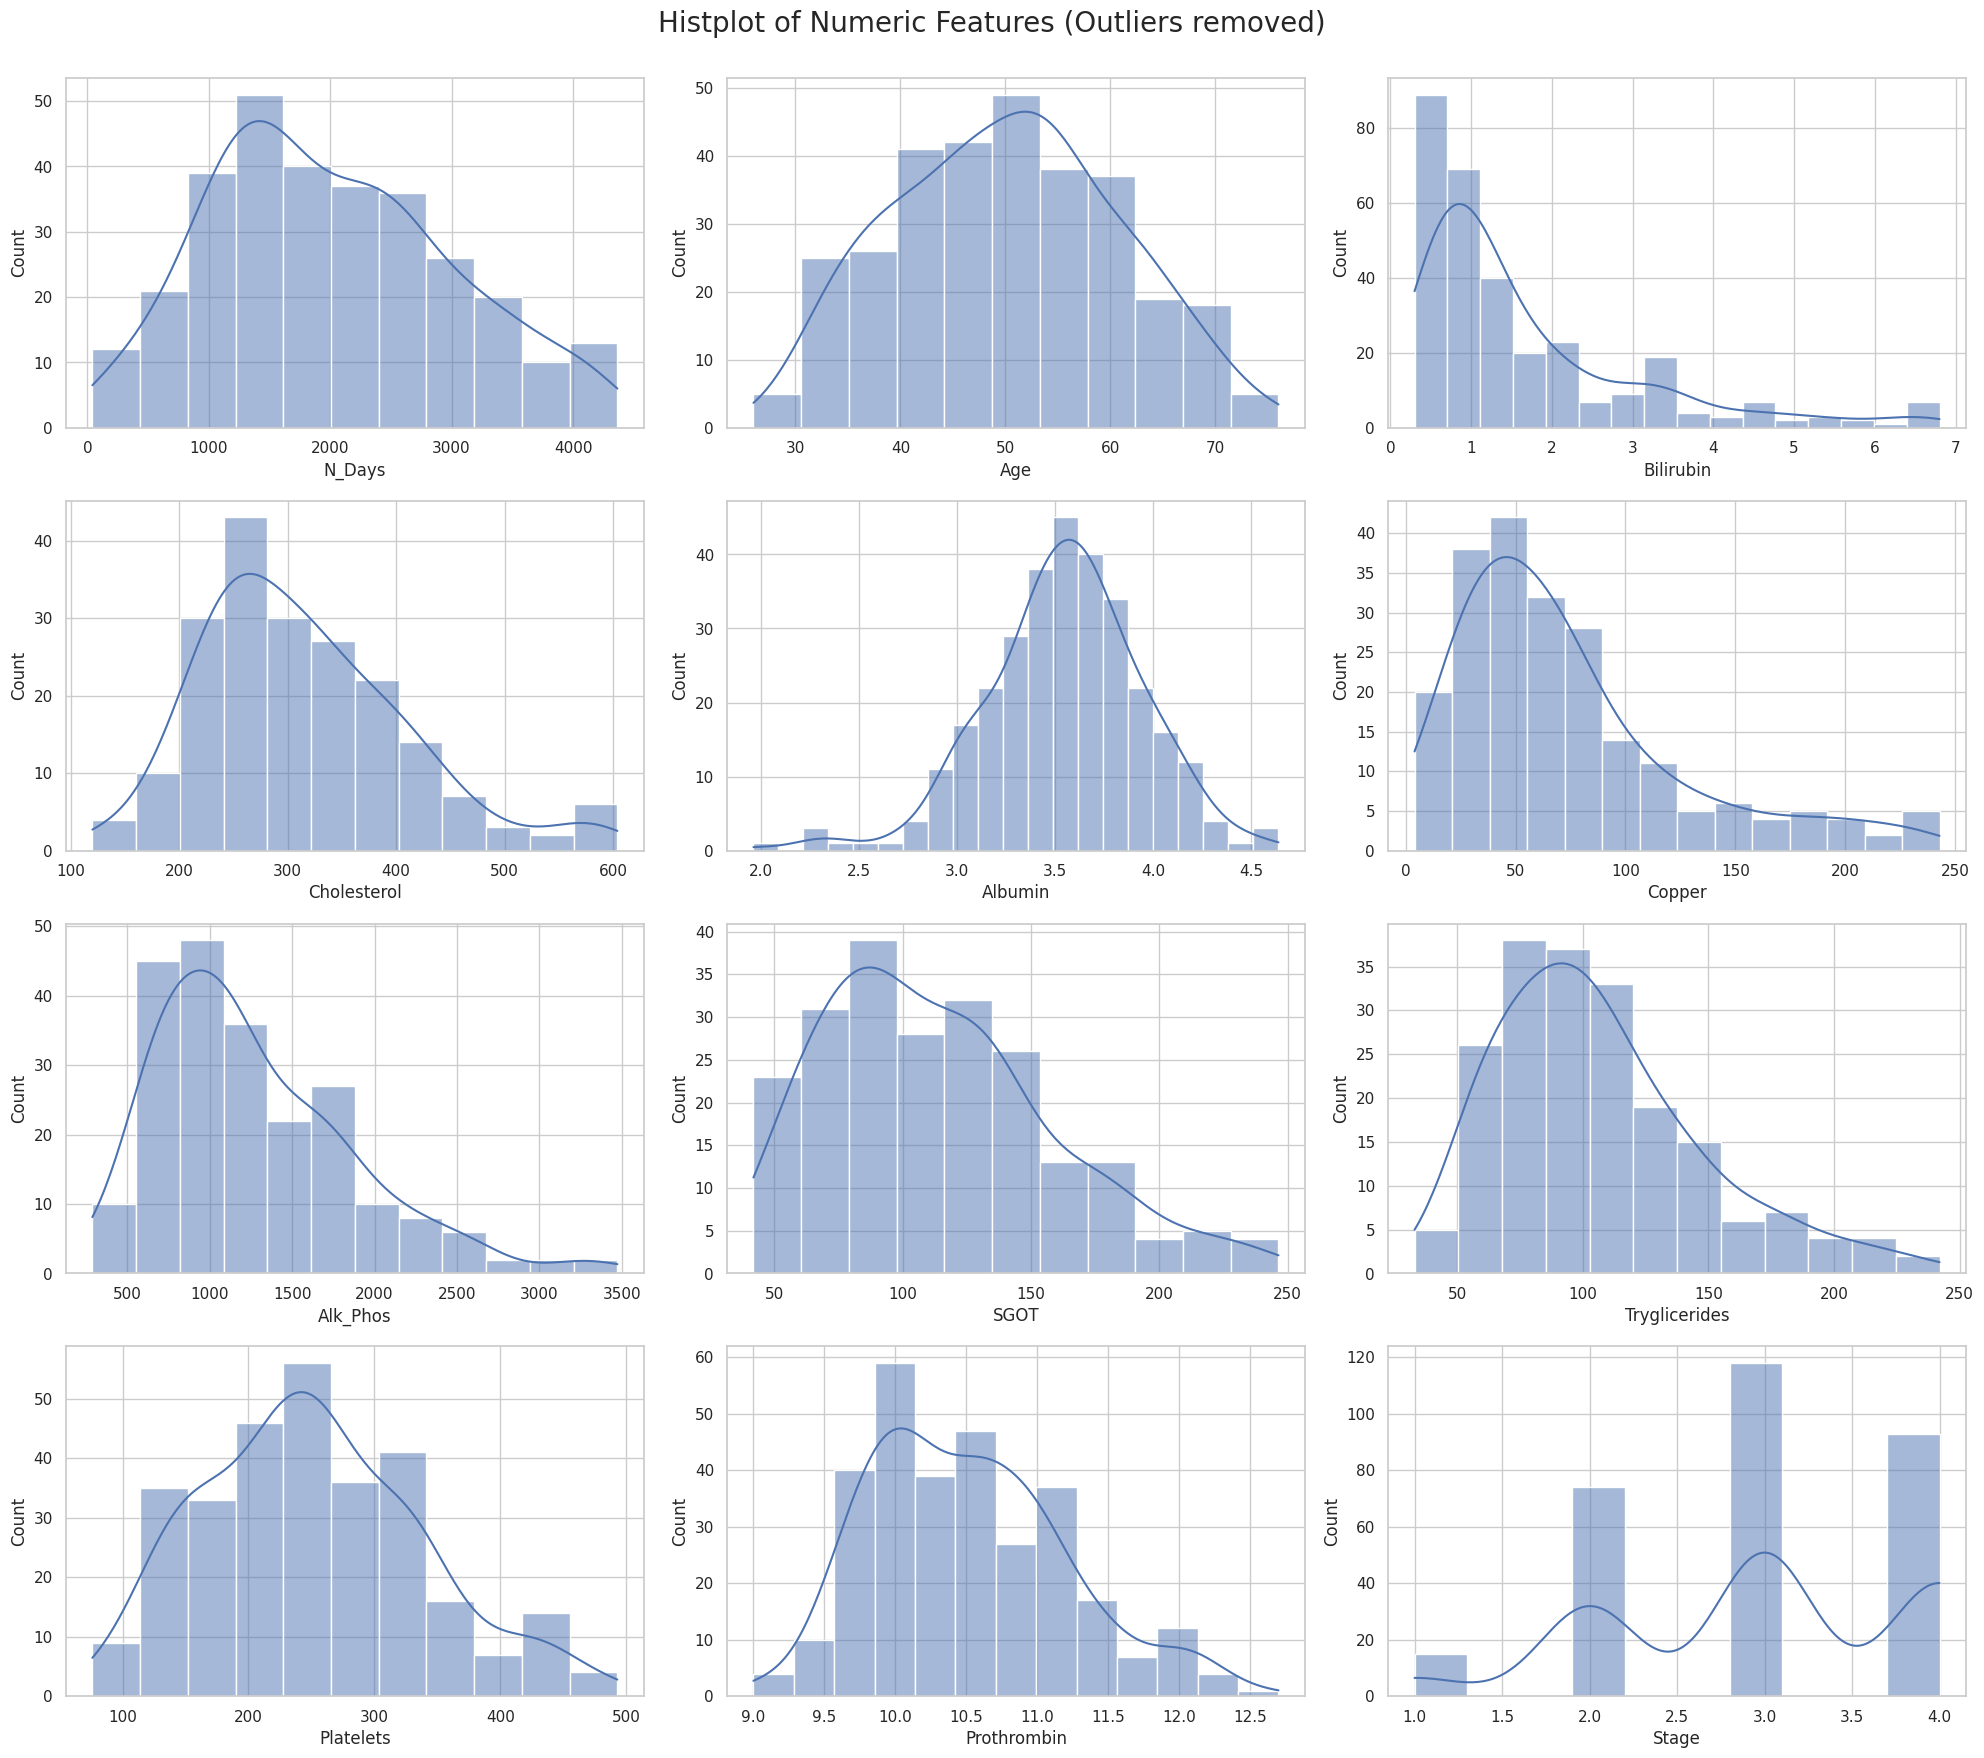

In [38]:
# Plot Histograms of numeric features
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_no_outliers):
    plt.subplot(6, 3, i + 1)
    sns.histplot(data=df_no_outliers, x=col, palette='viridis', kde=True)
    # plt.title(f'{col} by Stage')
    plt.tight_layout()

plt.suptitle('Histplot of Numeric Features (Outliers removed)', fontsize=20, y=1.02)
plt.show()

## Handling of missing values

In [39]:
df_cleaned = data_copy.copy()

In [40]:
df_cleaned.head()

N_Days Status             Drug  Age Sex Ascites Hepatomegaly Spiders Edema  \
0     400      D  D-penicillamine   58   F       Y            Y       Y     Y   
1    4500      C  D-penicillamine   56   F       N            Y       Y     N   
2    1012      D  D-penicillamine   70   M       N            N       N     S   
3    1925      D  D-penicillamine   54   F       N            Y       Y     S   
4    1504     CL          Placebo   38   F       N            Y       Y     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0       14.5        261.0     2.60   156.0    1718.0  137.95          172.0   
1        1.1        302.0     4.14    54.0    7394.8  113.52           88.0   
2        1.4        176.0     3.48   210.0     516.0   96.10           55.0   
3        1.8        244.0     2.54    64.0    6121.8   60.63           92.0   
4        3.4        279.0     3.53   143.0     671.0  113.15           72.0   

   Platelets  Prothrombin  Stage  
0      190.0         12.2    4.0  
1      221.0         10.6    3.0  
2      151.0         12.0    4.0  
3      183.0         10.3    4.0  
4      136.0         10.9    3.0

In [41]:
df_cleaned.isnull().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [42]:
cat_df.columns

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

## Missing Values imputation
Imputing ```Mode``` for categorical values and ```KNN``` for Numerical values. KNN used ```n_neighbours=5```

In [43]:
# --- Imputation ---
# Categorical: Mode
cat_cols = cat_df.columns
num_cols = df_num.columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df_cleaned[cat_cols] = cat_imputer.fit_transform(df_cleaned[cat_cols])

# Numerical: KNN
knn_imputer = KNNImputer(n_neighbors=5)
df_cleaned[num_cols] = knn_imputer.fit_transform(df_cleaned[num_cols])

# --- Validation of Imputation ---
print("\nMissing Values After Imputation:")
print(df_cleaned.isnull().sum())


Missing Values After Imputation:
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [44]:
data_copy.describe()

N_Days         Age   Bilirubin  Cholesterol     Albumin  \
count   418.000000  418.000000  418.000000   284.000000  418.000000   
mean   1917.782297   50.294258    3.220813   369.510563    3.497440   
std    1104.672992   10.471934    4.407506   231.944545    0.424972   
min      41.000000   26.000000    0.300000   120.000000    1.960000   
25%    1092.750000   42.000000    0.800000   249.500000    3.242500   
50%    1730.000000   51.000000    1.400000   309.500000    3.530000   
75%    2613.500000   58.000000    3.400000   400.000000    3.770000   
max    4795.000000   78.000000   28.000000  1775.000000    4.640000   

           Copper      Alk_Phos        SGOT  Tryglicerides   Platelets  \
count  310.000000    312.000000  312.000000     282.000000  407.000000   
mean    97.648387   1982.655769  122.556346     124.702128  257.024570   
std     85.613920   2140.388824   56.699525      65.148639   98.325585   
min      4.000000    289.000000   26.350000      33.000000   62.000000   
25%     41.250000    871.500000   80.600000      84.250000  188.500000   
50%     73.000000   1259.000000  114.700000     108.000000  251.000000   
75%    123.000000   1980.000000  151.900000     151.000000  318.000000   
max    588.000000  13862.400000  457.250000     598.000000  721.000000   

       Prothrombin       Stage  
count   416.000000  412.000000  
mean     10.731731    3.024272  
std       1.022000    0.882042  
min       9.000000    1.000000  
25%      10.000000    2.000000  
50%      10.600000    3.000000  
75%      11.100000    4.000000  
max      18.000000    4.000000

In [45]:
df_cleaned.describe()

N_Days         Age   Bilirubin  Cholesterol     Albumin  \
count   418.000000  418.000000  418.000000   418.000000  418.000000   
mean   1917.782297   50.294258    3.220813   368.222010    3.497440   
std    1104.672992   10.471934    4.407506   203.375349    0.424972   
min      41.000000   26.000000    0.300000   120.000000    1.960000   
25%    1092.750000   42.000000    0.800000   259.250000    3.242500   
50%    1730.000000   51.000000    1.400000   317.000000    3.530000   
75%    2613.500000   58.000000    3.400000   400.000000    3.770000   
max    4795.000000   78.000000   28.000000  1775.000000    4.640000   

           Copper      Alk_Phos        SGOT  Tryglicerides   Platelets  \
count  418.000000    418.000000  418.000000     418.000000  418.000000   
mean   100.992823   1920.948612  123.719402     123.217703  257.104785   
std     79.323167   1896.990669   50.758939      56.177268   97.282711   
min      4.000000    289.000000   26.350000      33.000000   62.000000   
25%     49.000000    976.750000   88.809500      90.000000  190.000000   
50%     78.500000   1381.500000  119.350000     112.800000  251.000000   
75%    128.450000   2008.700000  148.127500     144.150000  316.750000   
max    588.000000  13862.400000  457.250000     598.000000  721.000000   

       Prothrombin       Stage  
count   418.000000  418.000000  
mean     10.734306    3.025837  
std       1.020935    0.879122  
min       9.000000    1.000000  
25%      10.000000    2.000000  
50%      10.600000    3.000000  
75%      11.100000    4.000000  
max      18.000000    4.000000

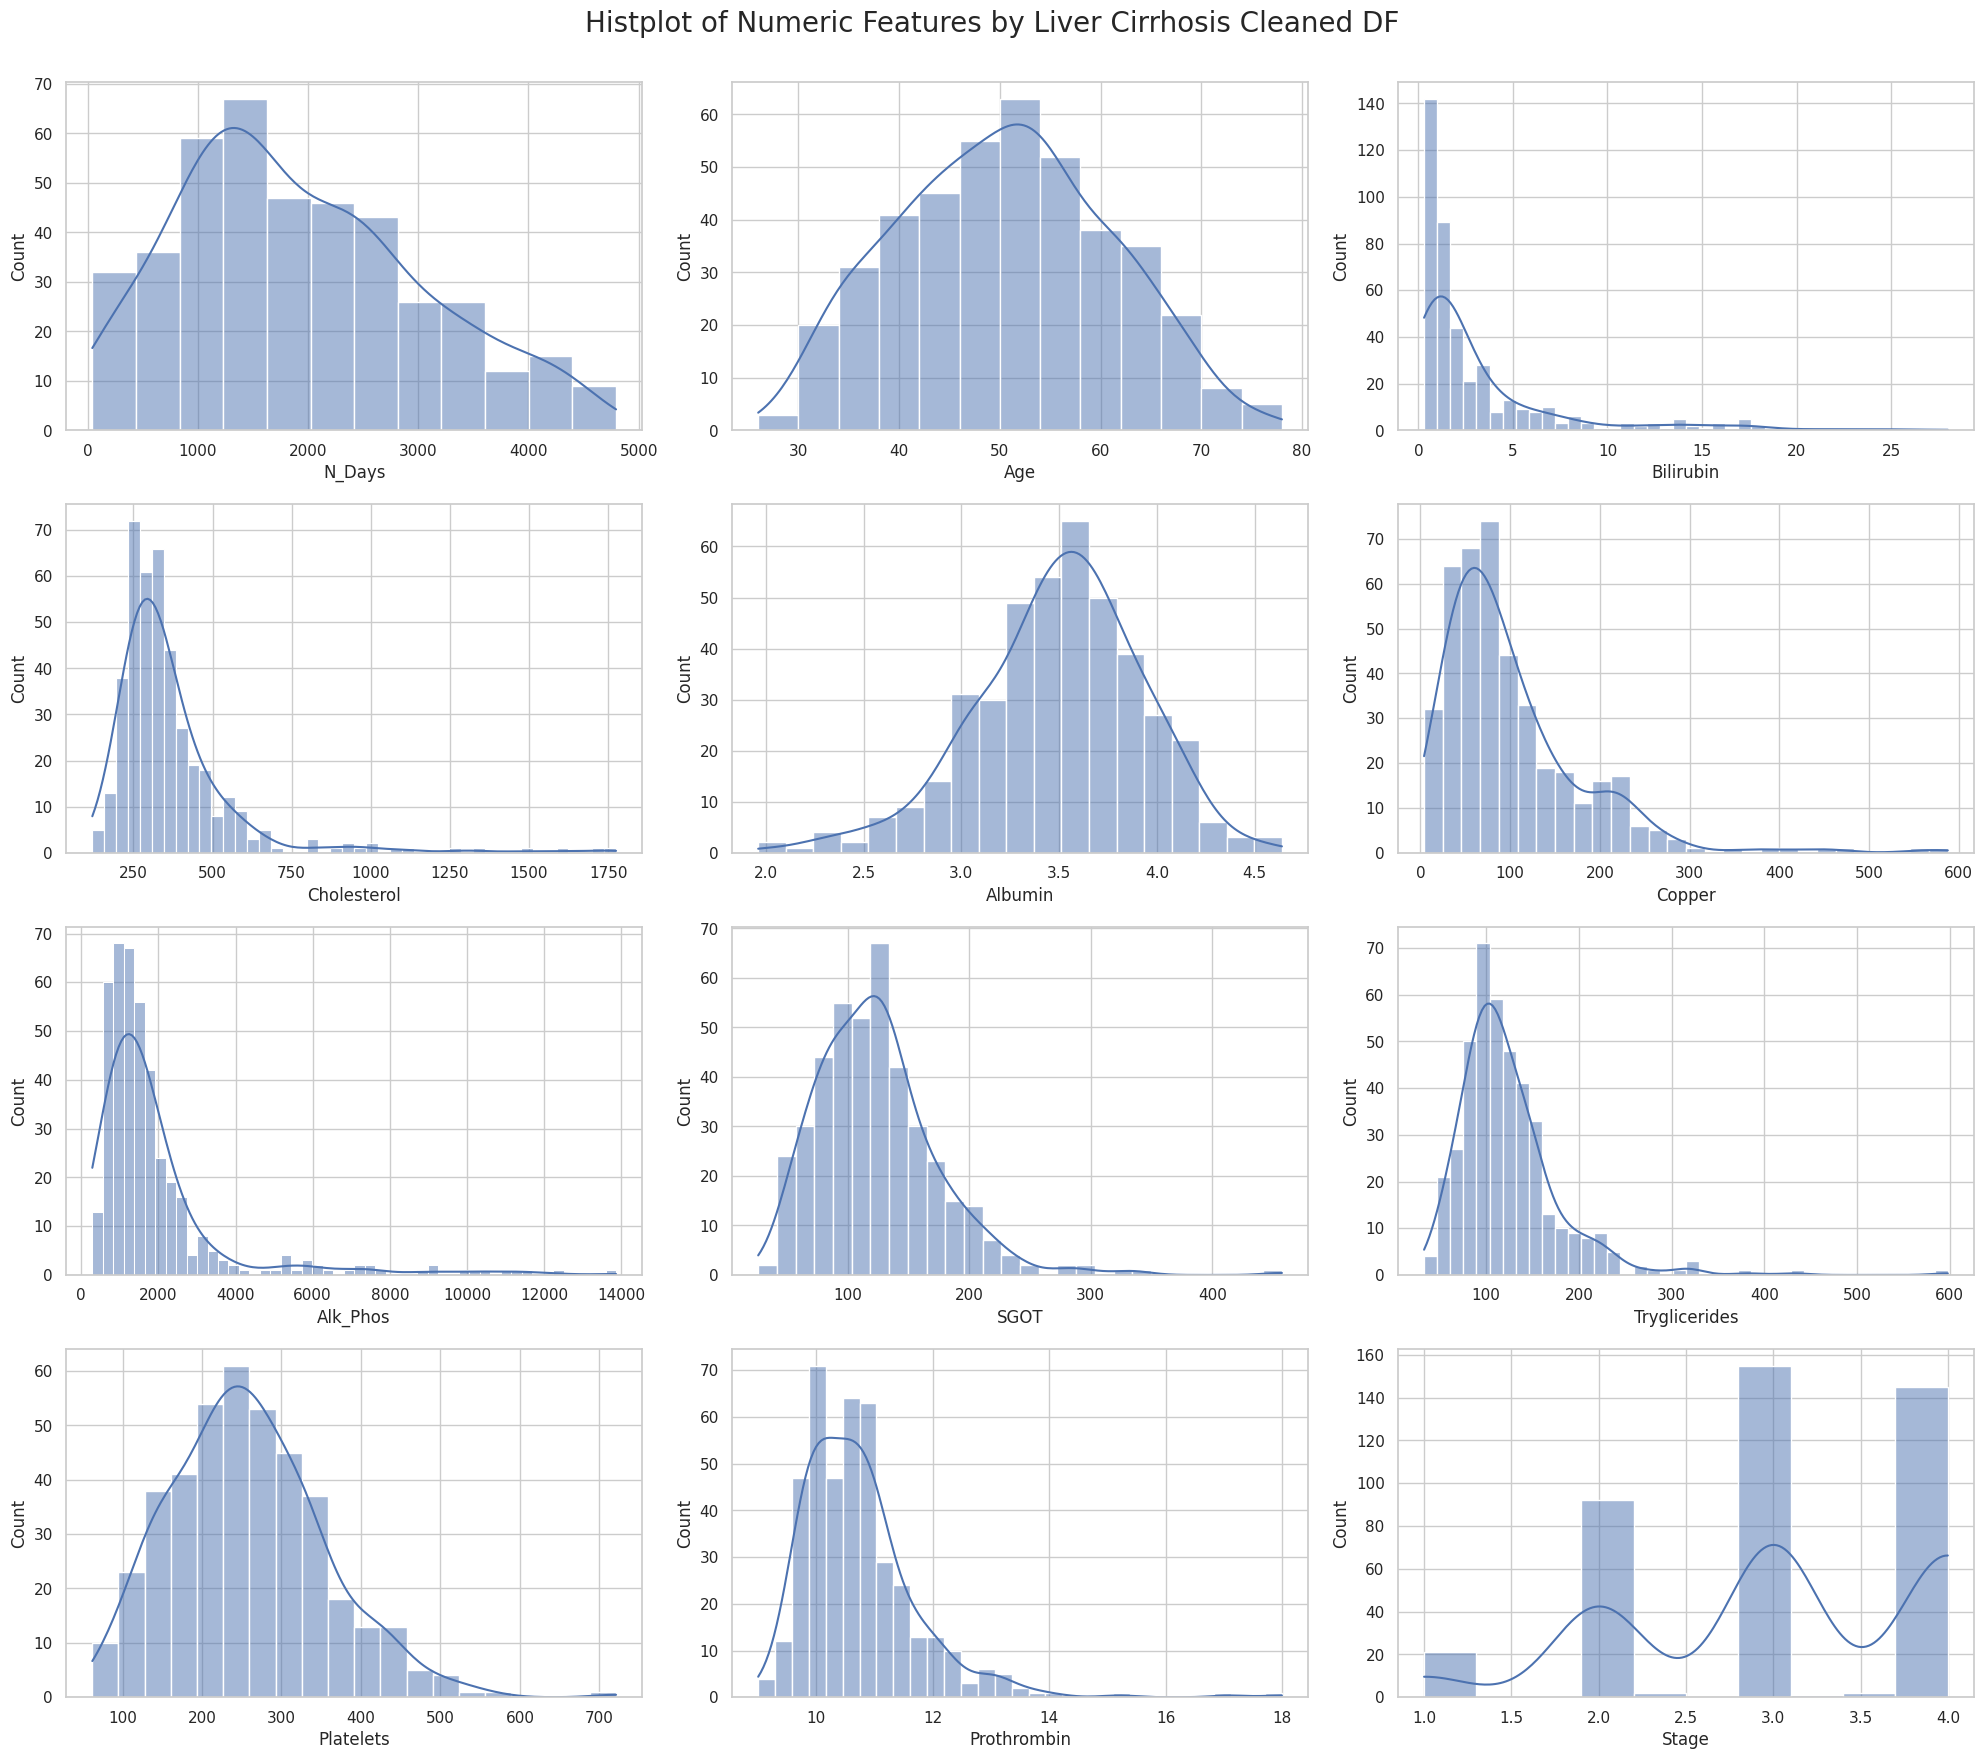

In [46]:
df_cleaned_num = df_cleaned.select_dtypes(include=['int64', 'float64'])
# Plot Histograms of numeric features
plt.figure(figsize=(20, 25))
for i, col in enumerate(df_cleaned_num):
    plt.subplot(6, 3, i + 1)
    sns.histplot(data=df_cleaned_num, x=col, palette='viridis', kde=True)
    # plt.title(f'{col} by Stage')
    plt.tight_layout()

plt.suptitle('Histplot of Numeric Features by Liver Cirrhosis Cleaned DF', fontsize=20, y=1.02)
plt.show()

## Outlier extraction for cleaned_df


Bilirubin: P1=0.40, P99=21.33
Outliers in Bilirubin: 8 rows

Copper: P1=11.00, P99=406.56
Outliers in Copper: 9 rows

SGOT: P1=43.67, P99=286.73
Outliers in SGOT: 10 rows

Cholesterol: P1=153.89, P99=1325.80
Outliers in Cholesterol: 10 rows

Alk_Phos: P1=415.53, P99=10936.13
Outliers in Alk_Phos: 10 rows

Tryglicerides: P1=49.17, P99=318.83
Outliers in Tryglicerides: 10 rows

Prothrombin: P1=9.32, P99=13.77
Outliers in Prothrombin: 10 rows

Platelets: P1=79.17, P99=516.49
Outliers in Platelets: 10 rows

Outlier DataFrame Shape: (66, 19)
No-Outlier DataFrame Shape: (352, 19)

Outliers DataFrame Descriptive Statistics:
       Bilirubin      Copper        SGOT  Cholesterol      Alk_Phos  \
count  66.000000   66.000000   66.000000    66.000000     66.000000   
mean    5.365152  130.563636  130.197515   441.039394   2769.268485   
std     7.354695  128.862192   83.622998   373.034143   3218.406851   
min     0.300000    4.000000   26.350000   120.000000    289.000000   
25%     0.700000   

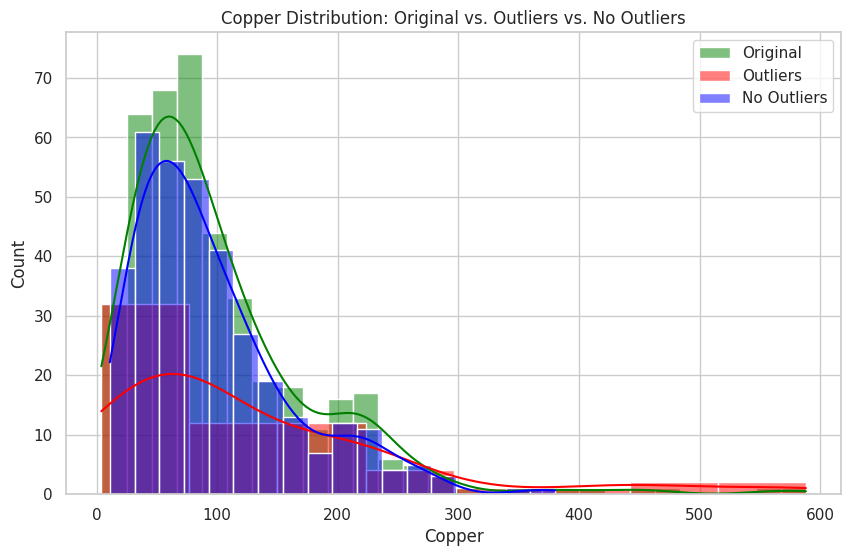

In [47]:
df = df_cleaned.copy()

# Define columns
num_cols = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
cat_cols = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
skewed_cols = ['Bilirubin', 'Copper', 'SGOT', 'Cholesterol', 'Alk_Phos', 'Tryglicerides', 'Prothrombin', 'Platelets']

# --- Identify Outliers (Percentile-Based Method) ---
outlier_mask = pd.DataFrame(False, index=df.index, columns=skewed_cols)
for col in skewed_cols:
    P1 = df[col].quantile(0.01)  # 1st percentile
    P99 = df[col].quantile(0.99) # 99th percentile
    print(f"\n{col}: P1={P1:.2f}, P99={P99:.2f}")
    outlier_mask[col] = (df[col] < P1) | (df[col] > P99)
    print(f"Outliers in {col}: {df[outlier_mask[col]].shape[0]} rows")

# Create DataFrames
df_outliers = df[outlier_mask.any(axis=1)].copy()
df_no_outliers = df[~outlier_mask.any(axis=1)].copy()
print(f"\nOutlier DataFrame Shape: {df_outliers.shape}")
print(f"No-Outlier DataFrame Shape: {df_no_outliers.shape}")

# --- Verify Outliers ---
print("\nOutliers DataFrame Descriptive Statistics:")
print(df_outliers[skewed_cols].describe())
print("\nNo-Outliers DataFrame Descriptive Statistics:")
print(df_no_outliers[skewed_cols].describe())

# --- Visualize Copper Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(df['Copper'], kde=True, color='green', label='Original', alpha=0.5)
sns.histplot(df_outliers['Copper'], kde=True, color='red', label='Outliers', alpha=0.5)
sns.histplot(df_no_outliers['Copper'], kde=True, color='blue', label='No Outliers', alpha=0.5)
plt.title('Copper Distribution: Original vs. Outliers vs. No Outliers')
plt.legend()
plt.show()

## GAN Training

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Epoch 0, D Loss: 0.5729414224624634, G Loss: 0.6800171136856079
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

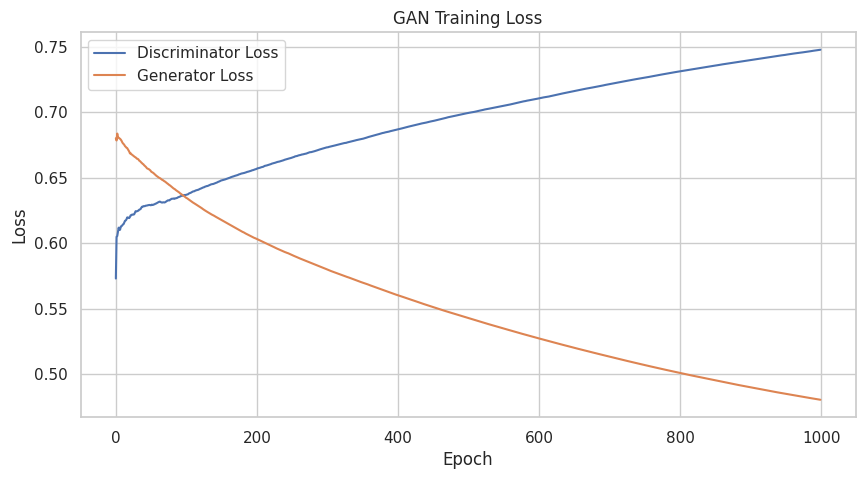

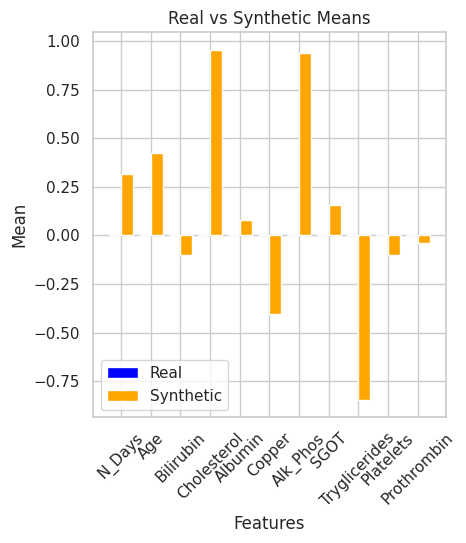

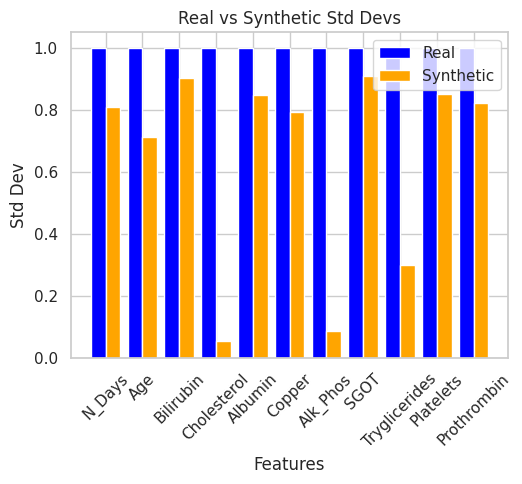


Proxy FID Score: 9.00

Real Data Stats (first 5 samples):
         N_Days       Age  Bilirubin  Cholesterol   Albumin    Copper  \
count  5.000000  5.000000   5.000000     5.000000  5.000000  5.000000   
mean  -0.044938  0.469027   0.276947    -0.570181 -0.564101  0.308062   
std    1.429513  1.095116   1.293263     0.235442  1.602059  0.829376   
min   -1.375612 -1.175427  -0.481759    -0.946291 -2.255651 -0.593132   
25%   -0.820938  0.354298  -0.413611    -0.611534 -2.114296 -0.466915   
50%   -0.375023  0.545513  -0.322748    -0.527844 -0.041088  0.530205   
75%    0.006542  0.736729   0.040704    -0.439232  0.076708  0.694288   
max    2.340341  1.884022   2.562152    -0.326005  1.513818  1.375863   

       Alk_Phos      SGOT  Tryglicerides  Platelets  Prothrombin  
count  5.000000  5.000000       5.000000   5.000000     5.000000  
mean   0.719563 -0.383631      -0.488642  -0.832643     0.456691  
std    1.708046  0.563960       0.802629   0.344992     0.835008  
min   -0.741507

In [89]:
# Define columns
num_cols = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
cat_cols = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

# --- Preprocessing ---
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Prepare data
X = df[num_cols + cat_cols].values
feature_dim = X.shape[1]

# --- GAN Architecture ---
def build_generator(latent_dim, feature_dim):
    model = Sequential([
        Dense(128, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(feature_dim, activation='tanh')
    ])
    return model

def build_discriminator(feature_dim):
    model = Sequential([
        Dense(256, input_dim=feature_dim),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

# Compile models
latent_dim = 100
generator = build_generator(latent_dim, feature_dim)
discriminator = build_discriminator(feature_dim)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# --- Training Parameters ---
epochs = 1000
batch_size = 32
sample_interval = 50

# --- Training History ---
d_losses = []
g_losses = []

# --- Training Loop ---
for epoch in range(epochs):
    # Generate random noise
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_data = generator.predict(noise)
    
    # Select real samples
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_data = X[idx]
    
    # Labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    # Train Discriminator
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels)
    
    # Store losses
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    
    if epoch % sample_interval == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        # Generate and save sample
        noise = np.random.normal(0, 1, (100, latent_dim))
        synthetic_data = generator.predict(noise)
        np.save(f'synthetic_data_epoch_{epoch}.npy', synthetic_data)

# --- Plot Training Progress ---
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('GAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Visualization: Real vs Synthetic Stats ---
synthetic_data = np.load('synthetic_data_epoch_950.npy')  # Load last saved data
synthetic_data_num = scaler.inverse_transform(synthetic_data[:, :len(num_cols)])
real_data_num = scaler.inverse_transform(X[:, :len(num_cols)])

real_means = np.mean(real_data_num, axis=0)
syn_means = np.mean(synthetic_data_num, axis=0)
real_stds = np.std(real_data_num, axis=0)
syn_stds = np.std(synthetic_data_num, axis=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(num_cols)) - 0.2, real_means, 0.4, label='Real', color='blue')
plt.bar(np.arange(len(num_cols)) + 0.2, syn_means, 0.4, label='Synthetic', color='orange')
plt.xlabel('Features')
plt.ylabel('Mean')
plt.title('Real vs Synthetic Means')
plt.xticks(np.arange(len(num_cols)), num_cols, rotation=45)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(num_cols)) - 0.2, real_stds, 0.4, label='Real', color='blue')
plt.bar(np.arange(len(num_cols)) + 0.2, syn_stds, 0.4, label='Synthetic', color='orange')
plt.xlabel('Features')
plt.ylabel('Std Dev')
plt.title('Real vs Synthetic Std Devs')
plt.xticks(np.arange(len(num_cols)), num_cols, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation: Proxy FID Score ---
def calculate_fid(real_data, synthetic_data):
    mu1, sigma1 = np.mean(real_data, axis=0), np.cov(real_data.T)
    mu2, sigma2 = np.mean(synthetic_data, axis=0), np.cov(synthetic_data.T)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

fid_score = calculate_fid(real_data_num, synthetic_data_num)
print(f"\nProxy FID Score: {fid_score:.2f}")

# --- Statistical Comparison ---
print("\nReal Data Stats (first 5 samples):")
print(pd.DataFrame(real_data_num[:5], columns=num_cols).describe())
print("\nSynthetic Data Stats (first 5 samples):")
print(pd.DataFrame(synthetic_data_num[:5], columns=num_cols).describe())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Epoch 0, D Loss: 0.5701799392700195, G Loss: 0.5926457643508911
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━

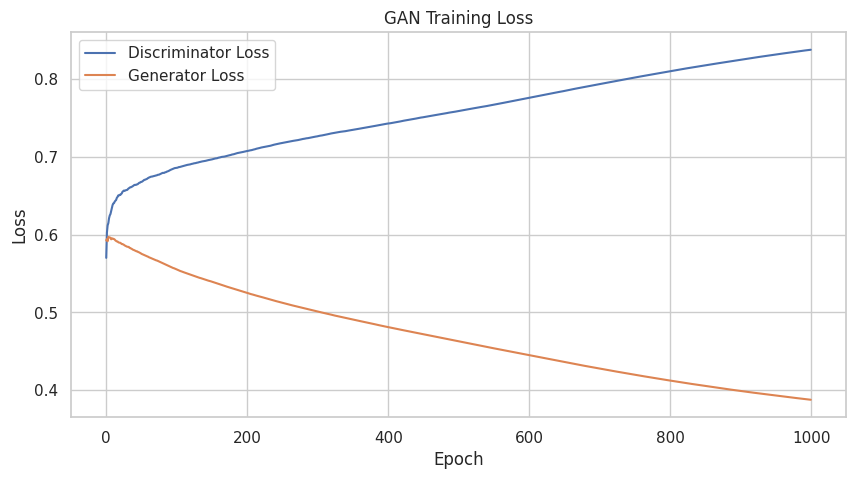

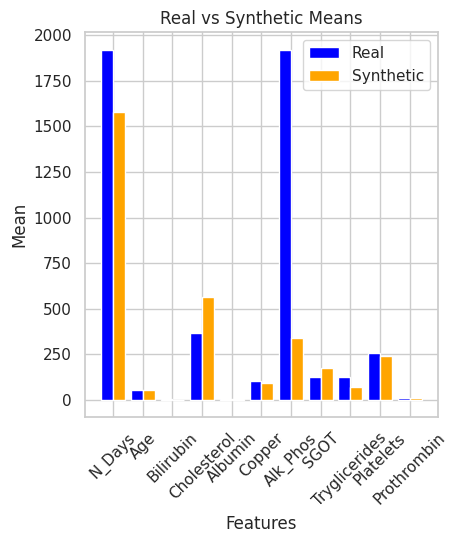

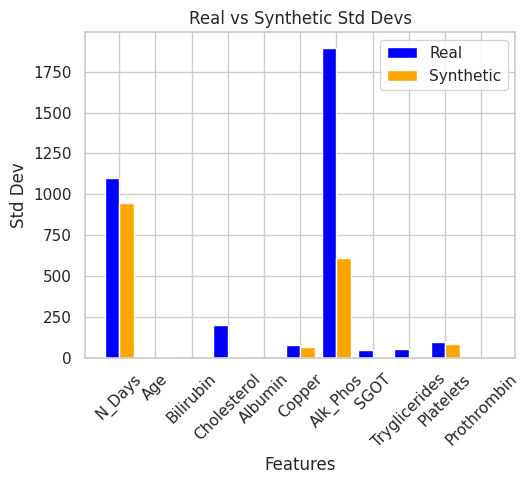


Proxy FID Score: 4454338.60

Real Data Stats (first 5 samples):
           N_Days        Age  Bilirubin  Cholesterol   Albumin      Copper  \
count     5.00000   5.000000   5.000000     5.000000  5.000000    5.000000   
mean   1868.20000  55.200000   4.440000   252.400000  3.258000  125.400000   
std    1577.25464  11.454257   5.693242    47.825725  0.680015   65.709969   
min     400.00000  38.000000   1.100000   176.000000  2.540000   54.000000   
25%    1012.00000  54.000000   1.400000   244.000000  2.600000   64.000000   
50%    1504.00000  56.000000   1.800000   261.000000  3.480000  143.000000   
75%    1925.00000  58.000000   3.400000   279.000000  3.530000  156.000000   
max    4500.00000  70.000000  14.500000   302.000000  4.140000  210.000000   

          Alk_Phos        SGOT  Tryglicerides   Platelets  Prothrombin  
count     5.000000    5.000000       5.000000    5.000000     5.000000  
mean   3284.320000  104.270000      95.800000  176.200000    11.200000  
std    3236.2

In [91]:
# Define columns
num_cols = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
cat_cols = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

# --- Preprocessing ---
le = LabelEncoder()
for col in cat_cols:
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))

scaler = StandardScaler()
df_cleaned[num_cols] = scaler.fit_transform(df_cleaned[num_cols])

# Prepare data
X = df[num_cols + cat_cols].values
feature_dim = X.shape[1]

# --- GAN Architecture ---
def build_generator(latent_dim, feature_dim):
    model = Sequential([
        Dense(128, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(feature_dim, activation='tanh')
    ])
    return model

def build_discriminator(feature_dim):
    model = Sequential([
        Dense(256, input_dim=feature_dim),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

# Compile models
latent_dim = 100
generator = build_generator(latent_dim, feature_dim)
discriminator = build_discriminator(feature_dim)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# --- Training Parameters ---
epochs = 1000
batch_size = 32
sample_interval = 50

# --- Training History ---
d_losses = []
g_losses = []

# --- Training Loop ---
for epoch in range(epochs):
    # Generate random noise
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_data = generator.predict(noise)
    
    # Select real samples
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_data = X[idx]
    
    # Labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    # Train Discriminator
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels)
    
    # Store losses
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    
    if epoch % sample_interval == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
        # Generate and save sample
        noise = np.random.normal(0, 1, (100, latent_dim))
        synthetic_data = generator.predict(noise)
        np.save(f'synthetic_data_epoch_{epoch}.npy', synthetic_data)

# --- Plot Training Progress ---
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('GAN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Visualization: Real vs Synthetic Stats ---
synthetic_data = np.load('synthetic_data_epoch_950.npy')  # Load last saved data
synthetic_data_num = scaler.inverse_transform(synthetic_data[:, :len(num_cols)])
real_data_num = scaler.inverse_transform(X[:, :len(num_cols)])

real_means = np.mean(real_data_num, axis=0)
syn_means = np.mean(synthetic_data_num, axis=0)
real_stds = np.std(real_data_num, axis=0)
syn_stds = np.std(synthetic_data_num, axis=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(num_cols)) - 0.2, real_means, 0.4, label='Real', color='blue')
plt.bar(np.arange(len(num_cols)) + 0.2, syn_means, 0.4, label='Synthetic', color='orange')
plt.xlabel('Features')
plt.ylabel('Mean')
plt.title('Real vs Synthetic Means')
plt.xticks(np.arange(len(num_cols)), num_cols, rotation=45)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(num_cols)) - 0.2, real_stds, 0.4, label='Real', color='blue')
plt.bar(np.arange(len(num_cols)) + 0.2, syn_stds, 0.4, label='Synthetic', color='orange')
plt.xlabel('Features')
plt.ylabel('Std Dev')
plt.title('Real vs Synthetic Std Devs')
plt.xticks(np.arange(len(num_cols)), num_cols, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluation: Proxy FID Score ---
def calculate_fid(real_data, synthetic_data):
    mu1, sigma1 = np.mean(real_data, axis=0), np.cov(real_data.T)
    mu2, sigma2 = np.mean(synthetic_data, axis=0), np.cov(synthetic_data.T)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

fid_score = calculate_fid(real_data_num, synthetic_data_num)
print(f"\nProxy FID Score: {fid_score:.2f}")

# --- Statistical Comparison ---
print("\nReal Data Stats (first 5 samples):")
print(pd.DataFrame(real_data_num[:5], columns=num_cols).describe())
print("\nSynthetic Data Stats (first 5 samples):")
print(pd.DataFrame(synthetic_data_num[:5], columns=num_cols).describe())